<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection(EDA)_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1064]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import re
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000
# pd.options.display.max_colwidth = 1000

## FUNCTIONS

#### Description Functions

In [1065]:

def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [1066]:
!pip install colorama
def column_details(regex, df=df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

#### Plot Functions

In [1067]:
def labels(ax, df=df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df),bar.get_height()), (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df=df, figsize=(20,6)):

    fig, ax = plt.subplots(1,2,figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                  order=np.sort(df[col].dropna().unique()),
                  )
    labels(ax[0],df[col].dropna(),(0, 0))
    
    ax_twin = ax[0].twinx()
    # sns.set(rc={"lines.linewidth": 0.7})
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', legend=False, 
                  order = np.sort(df[col].dropna().unique()), 
                  linewidth=0.1)
    

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                  order= np.sort(df[col].dropna().unique()),
                  )
    labels(ax[1],df[col].dropna())
    plt.show()


In [1068]:
def plot_cols(regex, figsize, target, df=df):
  columns=[col for col in df.columns if re.search(regex, col)]
  nrow, ncolumn = len(columns),1

  fig, ax = plt.subplots(nrow, ncolumn,figsize=figsize)

  for i,col in enumerate(columns):
      order = np.sort(df[col].dropna().unique())
      
      plt.subplot(nrow,ncolumn,i+1)
      ax[i] = sns.countplot(x=df[col], data= df, hue=target, order = order)
  #     labels(ax[i],df[col].dropna(),(0,0))
      
      tmp = pd.crosstab(df[col], df[target], normalize='index') * 100
      tmp = tmp.reset_index()
      tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
      
      ax_twin = ax[i].twinx()
  #     sns.set(rc={"lines.linewidth": 1})
      ax_twin = sns.pointplot(x=tmp[col], y=tmp['Fraud'],color='black', order = order)
      ax[i].grid();

In [1069]:
def hist_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)
  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.histplot(x=df[col], data= df, hue=target)
      else:
          sns.countplot(x=df[col], data= df, hue=target) 

In [1070]:
def box_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)

  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.boxplot(y=df[col], data= df, x=target)
      else:
          sns.countplot(x=df[col])

In [1071]:
def box_labels(ax, df, col1,col2):
    medians = df.groupby([col1])[col2].median().round(2)
    vertical_offset = df[col2].median() * 0.05 # offset from median for display

    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')

#### Correlation Functions

In [1072]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [1073]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

In [1074]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Outlier Functions

In [1075]:
def outliers(s):
  # summary of the outliers
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  sums = len(f)
  pros = len(f)/len(s)*100
  d = {'IQR':iqr,
        'Upper Bound':upper_bound,
      'Lower Bound':lower_bound,
      'Sum outliers': sums,'percentage outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['sub','values'])
  return(d)


In [1076]:
def capping_outliers(col, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)

  df[col] = np.where(df[col] < upper_bound, 
                                upper_bound,df[col])
  df[col] = np.where(df[col] > lower_bound, 
                                lower_bound,df[col])
  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);
  return df[col]

In [1077]:
def replace_outliers(col, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)
  if replaced_value=='median':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].median())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].median())
  elif replaced_value=='mean':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mean())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mean())
  elif replaced_value=='mode':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mode()[0])
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mode()[0])
  else:
    df[col] = df[col].mask(df[col] > upper_bound, replaced_value)
    df[col] = df[col].mask(df[col] < lower_bound, replaced_value)   

  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);

  return df[col]

In [1078]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f_sqrt), whis = 1.5)
    plt.xlabel("ROOT SQUARE - IQR=1.5")

    plt.subplot(144)
    plt.boxplot(df[col_name].apply(f_log), whis = 1.5)
    plt.xlabel("LOGARITMIC - IQR=1.5")
    plt.show()

In [1079]:
def plot_winsorize(df,col_name,down=0, up=0.1):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(root_winsor, bins=22)
    plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
    plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
    plt.xlabel('root_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(root_winsor, whis = 1.5)
    plt.xlabel("Root & Winsorize - IQR=1.5")
    plt.show() 

In [1080]:
def plot_log_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    log_winsor=winsorize(df[col_name].apply(f_log), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(log_winsor, bins=22)
    plt.axvline(x=log_winsor.mean()+3*log_winsor.std(),color='red')
    plt.axvline(x=log_winsor.mean()-3*log_winsor.std(),color='red')
    plt.xlabel('log_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(log_winsor, whis = 1.5)
    plt.xlabel("Log & Winsorize - IQR=1.5")
    plt.show()

In [1081]:
def simplify_column(col, df=df, rate=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<rate].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

### Memory Reduction Functions

In [1082]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

## Exploratory Data Analysis (EDA)

### Extract a 25k sample

In [1083]:
from google.colab import drive
drive.mount('/content/drive')

In [1084]:
# Take a 25k sample (%5 of train dataset)
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_reduced.csv',index_col=[0]).sample(n=25000, random_state=42)
data = data.sort_values('TransactionDT').reset_index().drop('index', axis=1)
df= data.copy()
# df = reduce_mem_usage_sd(df, verbose=True)
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987002        0          86469          59.000         W   4663   
1        2987006        0          86522         159.000         W  12308   
2        2987031        0          86998         363.890         W   6573   
3        2987111        0          88383          18.186         C  13832   
4        2987167        0          89169         100.000         H   6019   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
1  360.0  150.0        visa  166.0   debit  126.0   87.0    0.0    NaN   
2  583.0  150.0        visa  226.0  credit  315.0   87.0   13.0    NaN   
3  375.0  185.0  mastercard  224.0   debit    NaN    NaN    NaN  109.0   
4  583.0  150.0        visa  226.0  credit  325.0   87.0    NaN    NaN   

   P_emaildomain R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  \
0    outlook.com           NaN   1   1   0   0   0   1   0   0   1    0    1   
1      yahoo.com           NaN   1   1   0   0   0   1   0   0   1    0    1   
2      yahoo.com           NaN   1   1   0   0   1   1   0   0   1    0    1   
3    hotmail.com   hotmail.com   1   1   0   1   0   1   1   1   0    1    1   
4  optonline.net           NaN   1   1   0   0   0   1   0   1   0    1    1   

   C12  C13  C14   D1  D2  D3   D4  D5   D6  D7   D8   D9  D10    D11  D12  \
0    0    1    1  0.0 NaN NaN  0.0 NaN  NaN NaN  NaN  NaN  0.0  315.0  NaN   
1    0    1    1  0.0 NaN NaN  0.0 NaN  NaN NaN  NaN  NaN  0.0    0.0  NaN   
2    0    1    1  0.0 NaN NaN  0.0 NaN  NaN NaN  NaN  NaN  0.0    0.0  NaN   
3    1    1    1  0.0 NaN NaN  0.0 NaN  0.0 NaN  7.0  0.0  0.0    NaN  0.0   
4    0    1    1  0.0 NaN NaN  NaN NaN  NaN NaN  NaN  NaN  NaN    NaN  NaN   

   D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9   V1   V2  \
0  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F  1.0  1.0   
1  NaN  NaN    0.0    T    T    T   M0    F    F    T    T    T  1.0  1.0   
2  NaN  NaN    0.0    T    T    T  NaN  NaN    T    F    T    T  1.0  1.0   
3  0.0  0.0    0.0  NaN  NaN  NaN   M0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  \
0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  \
0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   

### Summarize data

In [1085]:
df.describe(include="all").T.sort_values("unique")

count unique                   top   freq  \
M7                       10317      2                     F   8965   
id_16                     5526      2                 Found   2799   
DeviceType                6051      2               desktop   3707   
id_12                     6195      2              NotFound   5277   
M9                       10320      2                     T   8719   
M8                       10320      2                     F   6563   
id_35                     6058      2                     T   3321   
M6                       17707      2                     F   9514   
id_28                     6058      2                 Found   3245   
M5                       10129      2                     F   5545   
M3                       13426      2                     T  10643   
M2                       13426      2                     T  12020   
M1                       13426      2                     T  13425   
id_37                     6058      2                     T   4719   
id_38                     6058      2                     F   3120   
card6                    24941      2                 debit  18637   
id_36                     6058      2                     F   5767   
id_29                     6058      2                 Found   3188   
id_27                      209      2                 Found    208   
id_15                     6058      3                 Found   2859   
M4                       13128      3                    M0   8298   
id_23                      209      3  IP_PROXY:TRANSPARENT    146   
id_34                     3323      3        match_status:2   2619   
card4                    24940      4                  visa  16293   
ProductCD                25000      5                     W  18510   
R_emaildomain             5903     53             gmail.com   2449   
P_emaildomain            20931     57             gmail.com   9646   
id_30                     3309     68            Windows 10    946   
id_33                     3109     76             1920x1080    734   
id_31                     6031    106           chrome 63.0    967   
DeviceInfo                5038    505               Windows   2101   
TransactionID            25000    NaN                   NaN    NaN   
isFraud                  25000    NaN                   NaN    NaN   
TransactionDT            25000    NaN                   NaN    NaN   
TransactionAmt           25000    NaN                   NaN    NaN   
card1                    25000    NaN                   NaN    NaN   
card2                    24632    NaN                   NaN    NaN   
card3                    24941    NaN                   NaN    NaN   
card5                    24814    NaN                   NaN    NaN   
addr1                    22173    NaN                   NaN    NaN   
addr2                    22173    NaN                   NaN    NaN   
dist1                    10023    NaN                   NaN    NaN   
dist2                     1590    NaN                   NaN    NaN   
C1                       25000    NaN                   NaN    NaN   
C2                       25000    NaN                   NaN    NaN   
C3                       25000    NaN                   NaN    NaN   
C4                       25000    NaN                   NaN    NaN   
C5                       25000    NaN                   NaN    NaN   
C6                       25000    NaN                   NaN    NaN   
C7                       25000    NaN                   NaN    NaN   
C8                       25000    NaN                   NaN    NaN   
C9                       25000    NaN                   NaN    NaN   
C10                      25000    NaN                   NaN    NaN   
C11                      25000    NaN                   NaN    NaN   
C12                      25000    NaN                   NaN    NaN   
C13                      25000    NaN                   NaN    NaN   
C14                      25000    N

In [1086]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(df).sort_values(by='Uniques', ascending=True))

Data shape: (25000, 436)
___________________________
Data Types:
float64    385
object      31
int64       20
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls      Min       Max
V305                     float64   25000        1      0        1         1
isFraud                    int64   25000        2      0        0         1
V1                       float64   13080        2  11920        1         1
V88                      float64   21168        3   3832        0         1
id_38                     object    6058        3  18942      NaN       NaN
DeviceType                object    6051        3  18949      NaN       NaN
M1                        object   13426        3  11574      NaN       NaN
M2                        object   13426        3  11574      NaN       NaN
M3                        object   13426        3  11574      NaN       NaN
M5                        object   10129        3  14871      NaN       NaN
M8                        object   10320        3  14680      NaN       NaN
V241                     float64    5619        3  19381        1         2
M9                        object   10320        3  14680      NaN       NaN
V68                      float64   21682        3   3318        0         1
V14                      float64   21742        3   3258        0         1
V65                      float64   21682        3   3318        0         1
V107                     float64   24984        3     16        0         1
V41                      float64   17787        3   7213        0         1
M7                        object   10317        3  14683      NaN       NaN
V240                     float64    5619        3  19381        1         2
M6                        object   17707        3   7293      NaN       NaN
V94                      float64   21168        3   3832        0         1
id_29                     object    6058        3  18942      NaN       NaN
id_35                     object    6058        3  18942      NaN       NaN
id_36                     object    6058        3  18942      NaN       NaN
card6                     object   24941        3     59      NaN       NaN
id_37                     object    6058        3  18942      NaN       NaN
id_12                     object    6195        3  18805      NaN       NaN
id_28                     object    6058        3  18942      NaN       NaN
id_16                     object    5526        3  19474      NaN       NaN
id_27                     object     209        3  24791      NaN       NaN
V121                     float64   24984        4     16        0         2
id_34                     object    3323        4  21677      NaN       NaN
V28                      float64   21742        4   3258        0         2
V122                     float64   24984        4     16        0         2
V120                     float64   24984        4     16        0         2
id_23                     object     209        4  24791      NaN       NaN
M4                        object   13128        4  11872      NaN       NaN
id_22                    float64     209        4  24791       14        41
id_15                     object    6058        4  18942      NaN       NaN
V117                     float64   24984        4     16        0         2
V27                      float64   21742        4   3258        0         2
V118                     float64   24984        4     16        0         2
V119                     float64   24984        4     16        0         2
V89                      float64   21168        4   3832        0         2
V50                      float64   17787        5   7213        0         3
V42                      float64   17787        5   7213        0         3
V36                      float64   17787        5   7213        0         3
V12                      float64   21742        5   3258        0         3
id_32                    float64    3311        5  21689        0        32
V35                      float64   17787        5   7213        0         3
V2                       float64   13080        5  11920        1         4

### Handling missing values

In [1087]:
missig_rate = np.product(df.isnull().sum().sum())/ np.product(df.shape)*100
print(f'% of missing data: {missig_rate:.2f}')

% of missing data: 44.81


In [1088]:
# import missingno as msno
# msno.matrix(df.sample(100));

In [1089]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)
null_values(df, 90)

Missing_Records  Percentage (%)
id_24            24814          99.256
id_07            24792          99.168
id_08            24792          99.168
id_21            24792          99.168
id_22            24791          99.164
id_23            24791          99.164
id_25            24791          99.164
id_26            24791          99.164
id_27            24791          99.164
dist2            23410          93.640
D7               23309          93.236
id_18            23047          92.188

In [1090]:
# Columns having Null values more than 90%  
many_null_cols = null_values(df, 90).index
print(many_null_cols)

Index(['id_24', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_25', 'id_26',
       'id_27', 'dist2', 'D7', 'id_18'],
      dtype='object')


In [1091]:
# Columns having a single value of more than %90 including missing values
big_top_value_cols_1 = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.90]
print(big_top_value_cols_1)

['isFraud', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [1092]:
# Columns having a single value of more than %97.5 except missing values
big_top_value_cols_2 = [col for col in df.columns if df[col].value_counts(dropna=True, normalize=True).values[0] > 0.975]
print(big_top_value_cols_2)

['addr2', 'C3', 'M1', 'V1', 'V14', 'V27', 'V28', 'V41', 'V46', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V138', 'V191', 'V193', 'V196', 'V240', 'V241', 'V247', 'V249', 'V252', 'V269', 'V305', 'id_04', 'id_27']


In [1093]:
# Columns having one unique value
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
one_value_cols

['V1', 'V305']

### Feature Engineering (TransactionDT)

In [1094]:
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)

### Drop redundant columns

In [1095]:
cols_to_drop = set(list(many_null_cols)+ big_top_value_cols_1 + big_top_value_cols_2 + one_value_cols)
cols_to_drop.remove('isFraud')
len(cols_to_drop)

89

In [1096]:
print(sorted(cols_to_drop))

['C3', 'D7', 'M1', 'V1', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V14', 'V191', 'V193', 'V196', 'V240', 'V241', 'V247', 'V249', 'V252', 'V269', 'V27', 'V28', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'V41', 'V46', 'V65', 'V68', 'V88', 'V89', 'V98', 'addr2', 'dist2', 'id_04', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [1097]:
df = df.drop(cols_to_drop, axis=1)

In [1098]:
print(list(df.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V

In [1099]:
df = df.drop('TransactionID', axis=1)

    **FEATURES**
- **`isFraud` : binary, Target**
- `TransactionID` : all unique 
- `TransactionDT` : time series
- `TransactionAmt` : continous, full
- `P_emaildomain` : categoric, 56 uniques
- `R_emaildomain` : categoric, 59 uniques
- `DeviceType` : categoric, 2 uniques
- `DeviceInfo` : categoric, 700 uniques
- `ProductCD` : categoric, 5 uniques
- `card1-6` : categoric 2, numeric 4  Abuzer
- `dist1-2` : numeric 2 Abuzer
- `C1-14` : numeric Abuzer
- `D1-15` : numeric Emrah
- `M1-9` : categoric Emrah
- `V1-339` : numeric, categoric
- `id_01_38` : numeric, categoric

### id_01-38

In [1100]:
columns=[]
column_details(regex='id_\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_01:  float64, 30, %75.22
[-100.  -95.  -90.  -87.  -85.  -80.  -75.  -70.  -65.  -60.  -55.  -50.
  -45.  -40.  -38.  -35.  -30.  -29.  -25.  -20.  -19.  -18.  -16.  -15.
  -14.  -12.  -10.   -7.   -5.    0.   nan]

id_02:  float64, 5998, %75.79
[1.32000e+02 1.42000e+02 2.08000e+02 ... 9.90150e+05 9.99595e+05
         nan]

id_03:  float64, 15, %88.8
[-10.  -7.  -6.  -5.  -4.  -3.  -2.   0.   1.   2.   3.   4.   5.   6.
   9.  nan]

id_05:  float64, 65, %76.5
[-30. -28. -25. -24. -22. -21. -20. -19. -18. -15. -14. -13. -12. -11.
 -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  35.  36.  38.  40.  41.  44.  45.  nan]

id_06:  float64, 79, %76.5
[-100.  -96.  -94.  -92.  -85.  -84.  -83.  -82.  -81.  -78.  -74.  -72.
  -71.  -70.  -69.  -67.  -65

#### id_30

In [1101]:
# grouping and converting data to the same standard
df.id_30.value_counts().sort_index().index

Index(['Android', 'Android 4.4.2', 'Android 5.0.2', 'Android 5.1.1',
       'Android 6.0', 'Android 6.0.1', 'Android 7.0', 'Android 7.1.1',
       'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0', 'Linux', 'Mac',
       'Mac OS X 10.10', 'Mac OS X 10.11', 'Mac OS X 10.12', 'Mac OS X 10.13',
       'Mac OS X 10.6', 'Mac OS X 10.9', 'Mac OS X 10_10_5',
       'Mac OS X 10_11_3', 'Mac OS X 10_11_5', 'Mac OS X 10_11_6',
       'Mac OS X 10_12', 'Mac OS X 10_12_1', 'Mac OS X 10_12_3',
       'Mac OS X 10_12_4', 'Mac OS X 10_12_5', 'Mac OS X 10_12_6',
       'Mac OS X 10_13_1', 'Mac OS X 10_13_2', 'Mac OS X 10_13_3',
       'Mac OS X 10_13_4', 'Mac OS X 10_6_8', 'Mac OS X 10_7_5',
       'Mac OS X 10_8_5', 'Mac OS X 10_9_5', 'Windows', 'Windows 10',
       'Windows 7', 'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP',
       'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',
       'iOS 10.3.1', 'iOS 10.3.2', 'iOS 10.3.3', 'iOS 11.0.0', 'iOS 11.0.1',
       'iOS 11.0.2'

In [1102]:
df.id_30.replace(regex={r'^Android.*': 'android', 
                        '^Mac.*': 'mac',
                        '^Windows.*': 'windows', 
                        '^iOS.*': 'ios',
                        '^Linux.*': 'linux'}, inplace=True)

df.id_30.value_counts(dropna=False)

NaN        21691
windows     1628
ios          816
mac          542
android      254
linux         68
other          1
Name: id_30, dtype: int64

#### id_31

In [1103]:
# grouping and converting data to the same standard
list(df.id_31.value_counts().sort_index().index)

['Generic/Android',
 'Generic/Android 7.0',
 'Microsoft/Windows',
 'Mozilla/Firefox',
 'Samsung/SM-G531H',
 'Samsung/SM-G532M',
 'android browser 4.0',
 'android webview 4.0',
 'aol',
 'chrome',
 'chrome 43.0 for android',
 'chrome 46.0 for android',
 'chrome 49.0',
 'chrome 49.0 for android',
 'chrome 50.0 for android',
 'chrome 51.0',
 'chrome 51.0 for android',
 'chrome 52.0 for android',
 'chrome 53.0 for android',
 'chrome 54.0 for android',
 'chrome 55.0',
 'chrome 55.0 for android',
 'chrome 56.0',
 'chrome 56.0 for android',
 'chrome 57.0',
 'chrome 57.0 for android',
 'chrome 58.0',
 'chrome 58.0 for android',
 'chrome 59.0',
 'chrome 59.0 for android',
 'chrome 60.0',
 'chrome 60.0 for android',
 'chrome 61.0',
 'chrome 61.0 for android',
 'chrome 62.0',
 'chrome 62.0 for android',
 'chrome 62.0 for ios',
 'chrome 63.0',
 'chrome 63.0 for android',
 'chrome 63.0 for ios',
 'chrome 64.0',
 'chrome 64.0 for android',
 'chrome 64.0 for ios',
 'chrome 65.0',
 'chrome 65.0 for and

In [1104]:
df.id_31.replace(regex={r'samsung.*': 'samsung_browser',
                        '^Samsung.*': 'samsung_browser',
                        '.*safari.*': 'safari',
                        'opera.*': 'opera', 
                        '^ie.*': 'ie',
                        'firefox.*': 'firefox',
                        '^Mozilla.*':'firefox',
                        'edge.*': 'edge', 
                        '^chrome.*': 'chrome',
                        '^google.*': 'chrome',
                        'android.*': 'android',
                        'Generic.*': 'android',
                        'Android':"android", 
                        'firefox.*': 'firefox',
                        'edge.*': 'edge', 
                        'Microsoft.*':'ie'}, inplace=True)

df.id_31.replace(df.id_31.value_counts(dropna=False)[df.id_31.value_counts(dropna=False)<10].index,'other', inplace= True)

df.id_31.value_counts(dropna=False)

NaN                18969
chrome              3258
safari              1606
ie                   434
firefox              289
edge                 287
samsung_browser       92
android               27
opera                 19
other                 19
Name: id_31, dtype: int64

#### id_33

In [1105]:
# dtype transformation and discretization
df.id_33.value_counts(dropna=False).head(5)

NaN          21891
1920x1080      734
1366x768       369
1334x750       271
2208x1242      196
Name: id_33, dtype: int64

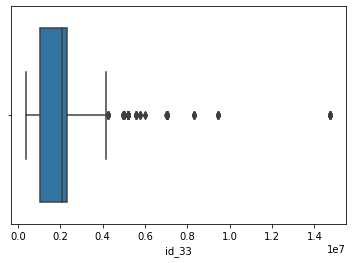

In [1106]:
df.id_33 = df.id_33.fillna(value='0x0').str.extract('(\d*)x(\d*)').apply(lambda x: int(x[0])*int(x[1]), axis=1)
df.id_33 = df.id_33.replace({0:np.nan})
sns.boxplot(df.id_33);

In [1107]:
df.id_33.value_counts()

2073600.0     734
1049088.0     369
1000500.0     271
2742336.0     196
1296000.0     190
1440000.0     165
3145728.0     136
1024000.0      89
1310720.0      79
4096000.0      77
727040.0       76
3686400.0      72
1764000.0      68
5184000.0      64
2740500.0      61
2304000.0      60
2251125.0      53
921600.0       47
786432.0       41
2397600.0      24
7056000.0      21
1047722.0      18
1044480.0      17
14745600.0     15
3110400.0      15
4990464.0      11
5595136.0      10
4269762.0       9
9437184.0       9
614400.0        7
3709632.0       7
2399820.0       7
8294400.0       6
5760000.0       5
4953600.0       5
410400.0        5
3694404.0       5
518400.0        4
983040.0        4
995328.0        4
1920000.0       4
3240000.0       4
3847680.0       3
1679616.0       3
2076601.0       3
1327104.0       2
1470000.0       2
384480.0        2
2459520.0       2
1439100.0       2
6000000.0       2
2764800.0       1
6998400.0       1
1438400.0       1
1312000.0       1
1016064.0 

In [1108]:
# in the data description, it is given that "id_12 - id_38" columns are categorical

nominal_cols = ['id_12','id_15','id_16','id_28','id_29','id_30','id_31','id_34', 'id_35', 'id_36', 'id_37', 'id_38']
ordinal_cols = ['id_13', 'id_14','id_17', 'id_19', 'id_20','id_32','id_33']

numeric_cols = sorted(set(columns).difference(set(nominal_cols+ordinal_cols)))
print(f"numeric_cols:\n{numeric_cols}")

numeric_cols:
['id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11']


#### Multicollinearity

In [1109]:
# column_details(regex='id_\d*')

In [1110]:
# missing value correlation
# msno.heatmap(df[columns], figsize=(15, 8), fontsize=10);

In [1111]:
# # Feature correlations
# plt.figure(figsize=(15,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1112]:
# corrank(df[columns], 0.8)

In [1113]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

set()

In [1114]:
cat_columns=['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
pd.Series([cramers_v(df.id_28,df[col]) for col in cat_columns], index=cat_columns).sort_values(ascending=False)
# cramers_v(df.id_28,df.id_16)

id_28    0.999668
id_29    0.980952
id_15    0.879425
id_16    0.870756
id_33    0.367226
id_30    0.360223
id_37    0.344175
id_31    0.329548
id_32    0.322144
id_34    0.311073
id_12    0.304158
id_35    0.080517
id_36    0.072590
id_38    0.071541
dtype: float64

> Multicolliniarity treshold is  having upper than 0.8

In [1115]:
drop_col=['id_15','id_16','id_29']
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [1116]:
columns=[col for col in df.columns if re.search('^id', col)]
print(columns)

['id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_28', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [1117]:
# outliers(df.id_01.dropna())

In [1118]:
# for col in columns[:8]:
#   col_plot(df[col].dropna().to_frame(),col)

In [1119]:
# for col in columns[:8]:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [1120]:
# for col in columns[:8]:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [1121]:
# df['id_11'] = data['id_11'].copy()
# df['id_11'].value_counts()

In [1122]:
df['id_01'] = data['id_01'].copy()
df['id_01']= df.id_01.apply(lambda x: 1 if x!=-5 else 0)
# df['id_02'] = pd.Series( winsorize(df.id_02, limits=(0, 0.1)))
df['id_02'] = df.id_02**0.35
df['id_03']= df.id_03.apply(lambda x: 1 if x!=0 else x)
df['id_05']= df.id_05.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
df['id_06']= df.id_06.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
df['id_09']= df.id_09.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
df['id_10']= df.id_09.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
df['id_11'] = df.id_11.apply(lambda x: 0 if x<100 else 1)

#### Plots

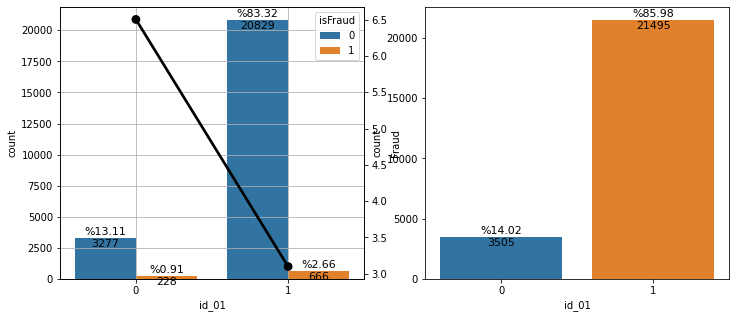

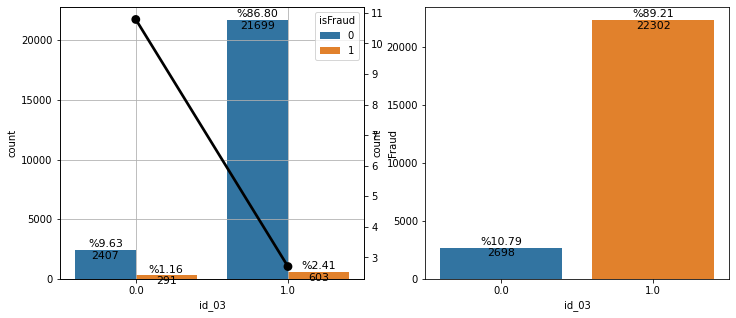

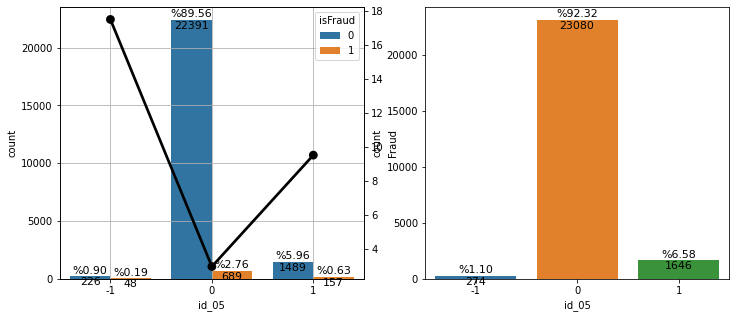

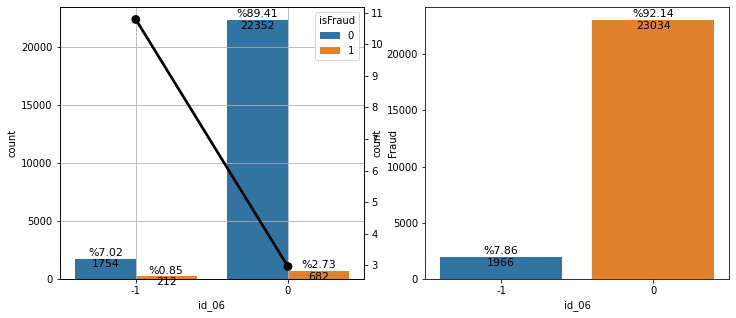

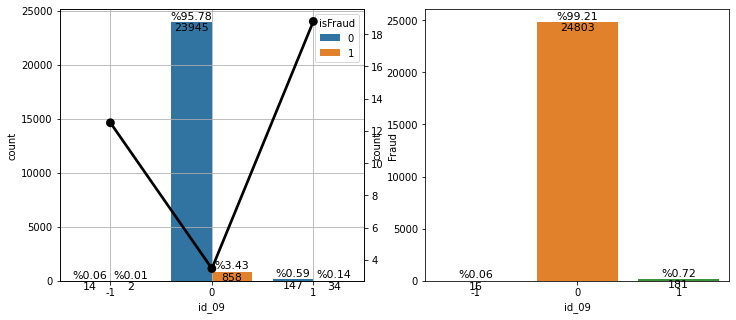

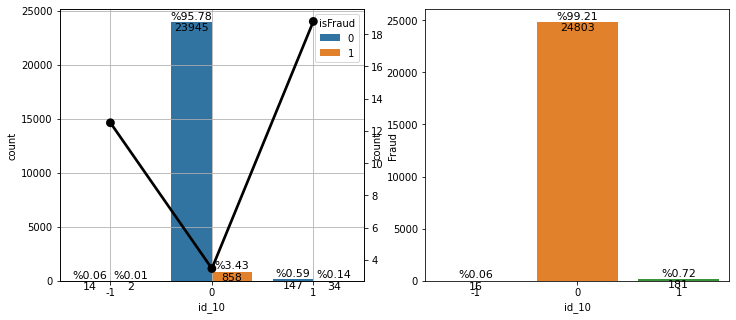

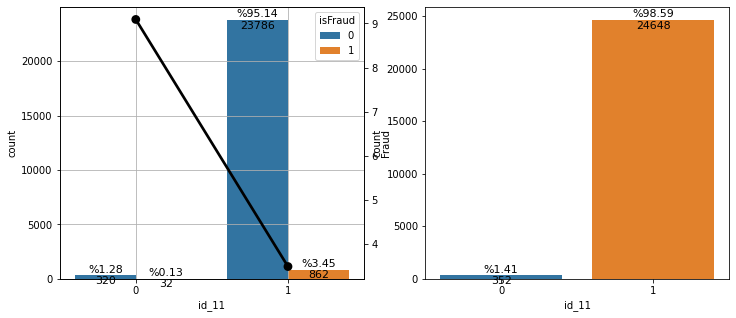

In [1123]:
for col in ['id_01', 'id_03', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11']:
  plot_col(col, df=df, figsize=(12,5))

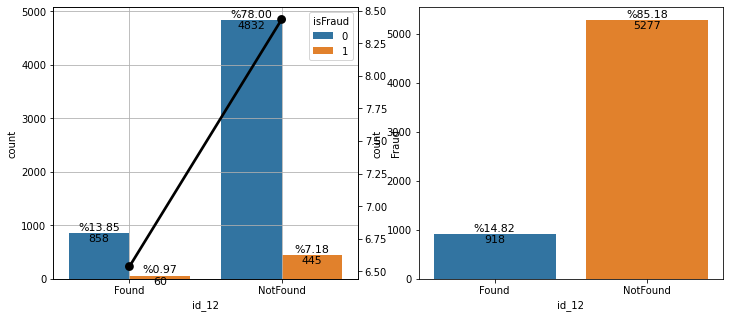

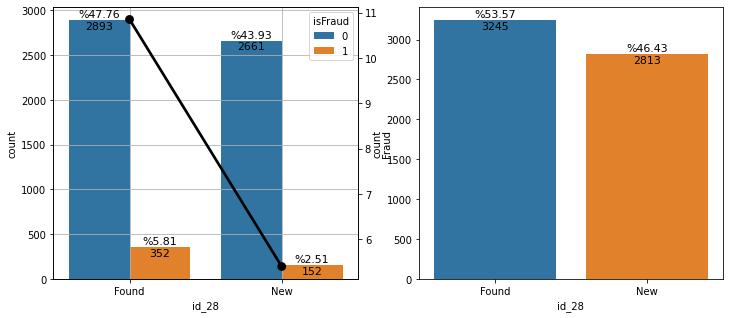

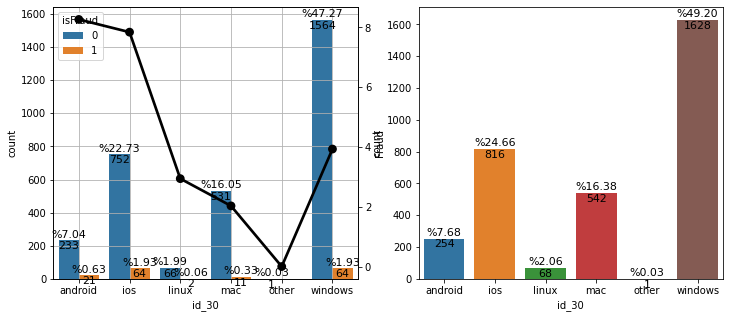

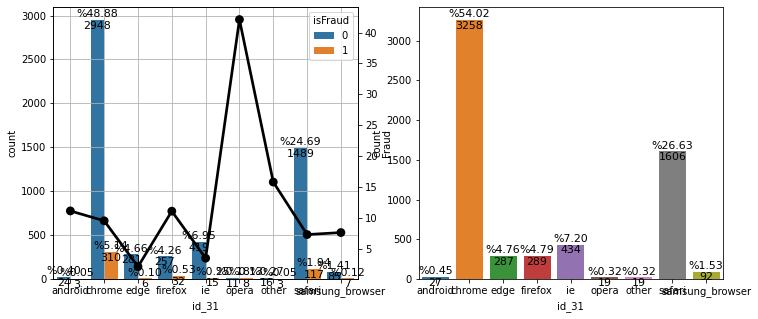

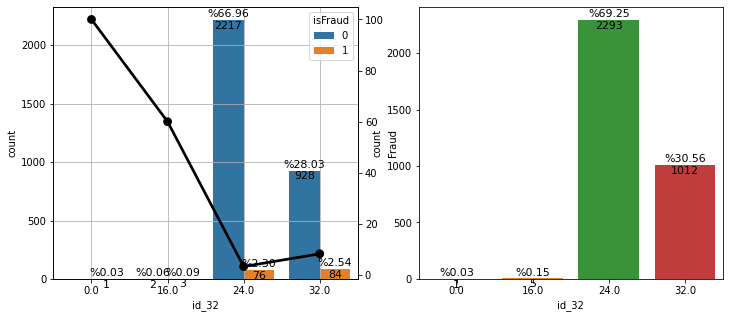

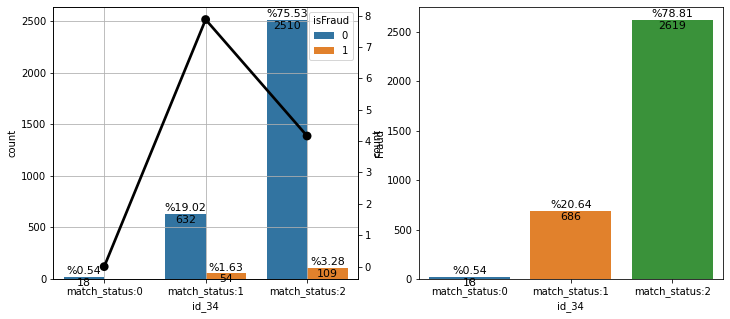

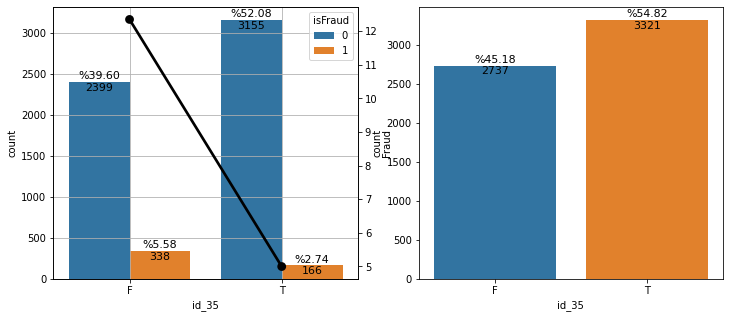

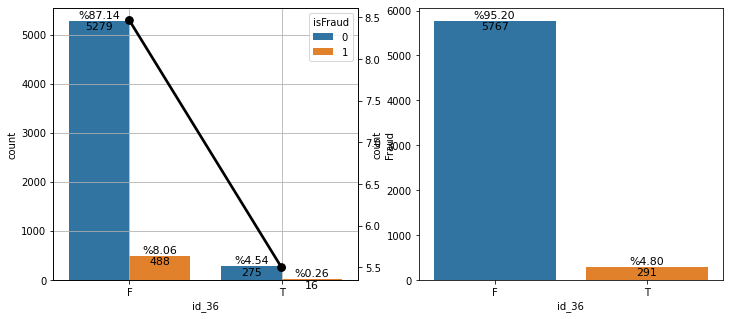

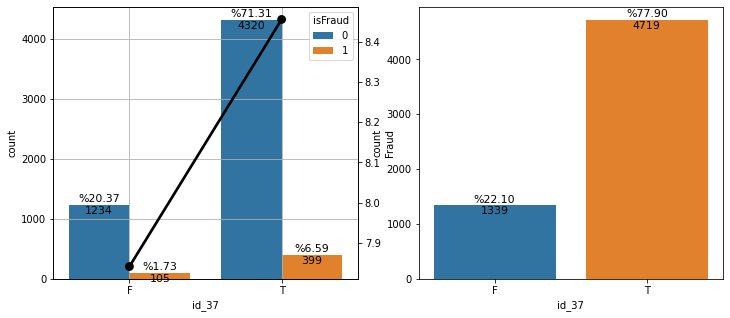

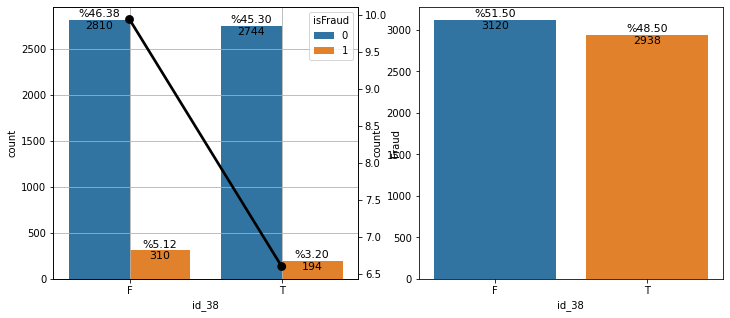

In [1124]:
for col in ['id_12','id_28','id_30', 'id_31', 'id_32','id_34','id_35','id_36','id_37','id_38']:
  plot_col(col, df=df, figsize=(12,5))

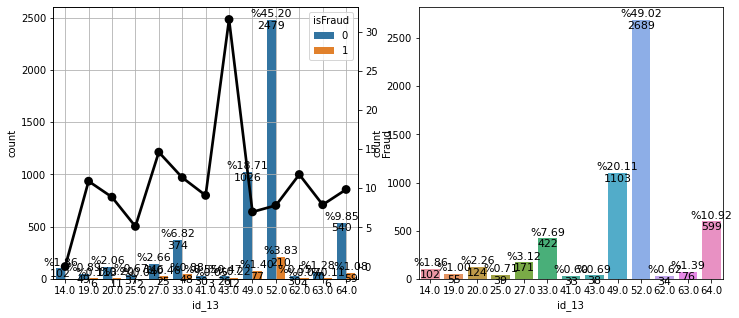

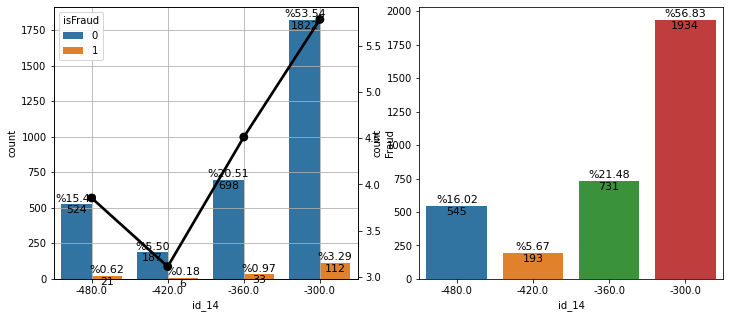

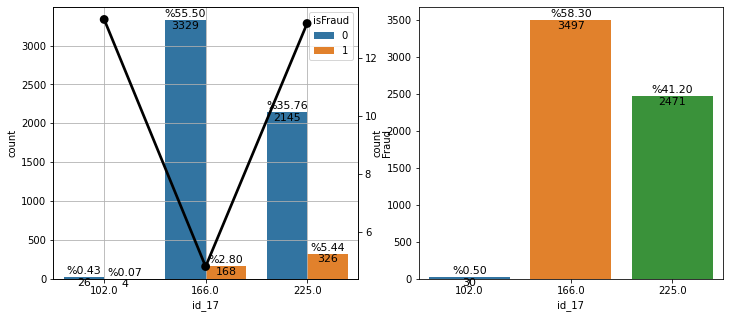

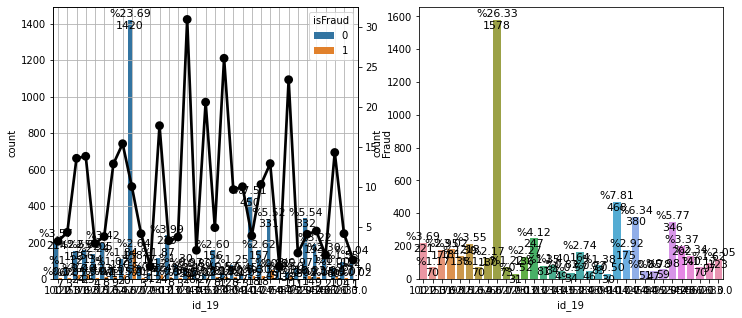

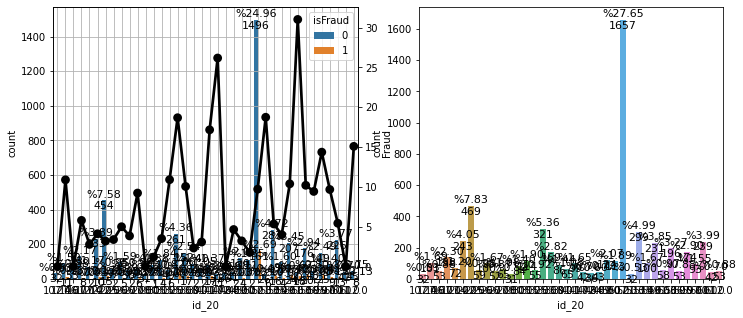

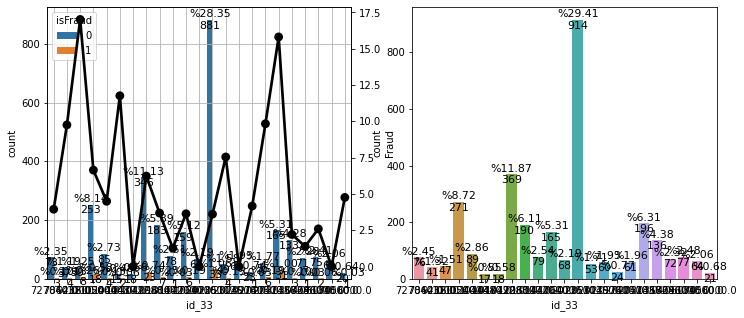

In [1125]:
for col in ['id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_33']:
  df[col] = simplify_column(col, df=df, rate=0.005 )
  plot_col(col, df=df, figsize=(12,5))

In [1126]:
# plot_cols(regex='id_\d*', figsize=(10, 25), target='isFraud', df=df)

In [1127]:
# hist_countplot(regex='id_\d*', figsize=(30, 60), nrow=10, ncolumn = 4, df=df)

In [1128]:
# box_countplot(regex='id_\d*', figsize=(30, 60), nrow=10, ncolumn = 4, df=df)

### V1-339

#### Multicolliniarity

In [1129]:
column_details(regex='V\d*')

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V2:  float64, 2, %47.68
[ 1.  2. nan]

V3:  float64, 3, %47.68
[ 1.  2.  3. nan]

V4:  float64, 3, %47.68
[ 0.  1.  2. nan]

V6:  float64, 2, %47.68
[ 1.  2. nan]

V7:  float64, 3, %47.68
[ 1.  2.  3. nan]

V8:  float64, 2, %47.68
[ 1.  2. nan]

V10:  float64, 3, %47.68
[ 0.  1.  2. nan]

V12:  float64, 3, %13.03
[ 0.  1.  2. nan]

V15:  float64, 2, %13.03
[ 0.  1. nan]

V19:  float64, 3, %13.03
[ 0.  1.  2. nan]

V23:  float64, 2, %13.03
[ 1.  2. nan]

V25:  float64, 2, %13.03
[ 0.  1. nan]

V35:  float64, 3, %28.85
[ 0.  1.  2. nan]

V37:  float64, 3, %28.85
[ 1.  2.  3. nan]

V44:  float64, 3, %28.85
[ 1.  2.  3. nan]

V47:  float64, 2, %28.85
[ 1.  2. nan]

V53:  float64, 3, %13.27
[ 0.  1.  2. nan]

V55:  float64, 3, %13.27
[ 1.  2.  3. nan]

V56:  float64, 3, %13.27
[ 1.  2.  3. nan]

V61:  float64, 3, %13.27
[ 0.  1.  2. nan]

V66:  float64, 3, %13.27
[ 0.  1.  2. nan]

V75:  float64, 3, %15.33
[ 0.  1.  2. nan]


In [1130]:
len(columns)

74

**V Features Groups according to the missing value correlation**

* V2-11
* V12-34
* V35-52
* V53-74
* V75-94
* V95-131
* V139-166
* V167-216
* V217-278
* V279-317
* V322-339

##### V2-11

In [1131]:
columns = [f'V{i}' for i in range(2,12) if f'V{i}' in columns ]
columns

['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10']

In [1132]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [1133]:
# plt.figure(figsize=(10,7))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1134]:
# corrank(df[columns], 0.8)

In [1135]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

set()

In [1136]:
df = df.drop(drop_col, axis=1)

##### V12-34

In [1137]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(12,35) if f'V{i}' in columns ]
columns

['V12',
 'V13',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34']

In [1138]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1139]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1140]:
# corrank(df[columns], 0.8)

In [1141]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V13',
 'V16',
 'V17',
 'V18',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34'}

In [1142]:
df = df.drop(drop_col, axis=1)

##### V35-52

In [1143]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(35,53) if f'V{i}' in columns ]
columns

['V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52']

In [1144]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1145]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1146]:
# corrank(df[columns], 0.8)

In [1147]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V36', 'V38', 'V40', 'V42', 'V43', 'V45', 'V49', 'V50', 'V51', 'V52'}

In [1148]:
df = df.drop(drop_col, axis=1)

##### V53-74

In [1149]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(53,75) if f'V{i}' in columns ]
columns

['V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V66',
 'V67',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74']

In [1150]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1151]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1152]:
# corrank(df[columns], 0.8)

In [1153]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V54',
 'V58',
 'V59',
 'V60',
 'V62',
 'V63',
 'V64',
 'V67',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74'}

In [1154]:
df = df.drop(drop_col, axis=1)

##### V75-94

In [1155]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(75,95) if f'V{i}' in columns ]
columns

['V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94']

In [1156]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1157]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1158]:
# corrank(df[columns], 0.8)

In [1159]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V76', 'V81', 'V83', 'V84', 'V85', 'V87', 'V91', 'V92', 'V93', 'V94'}

In [1160]:
df = df.drop(drop_col, axis=1)

##### V95-131

In [1161]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(95,132) if f'V{i}' in columns ]
columns

['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']

In [1162]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1163]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1164]:
# corrank(df[columns], 0.8)

In [1165]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V100', 'V126', 'V127', 'V128', 'V96', 'V97'}

In [1166]:
df = df.drop(drop_col, axis=1)

##### V132-166

In [1167]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(132,167) if f'V{i}' in columns ]
columns

['V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166']

In [1168]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1169]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1170]:
# corrank(df[columns], 0.8)

In [1171]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V140',
 'V142',
 'V145',
 'V147',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166'}

In [1172]:
df = df.drop(drop_col, axis=1)

##### V167-216

In [1173]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(167,217) if f'V{i}' in columns ]
columns

['V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V192',
 'V194',
 'V195',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216']

In [1174]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1175]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1176]:
# corrank(df[columns], 0.8)

In [1177]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V168',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V185',
 'V186',
 'V189',
 'V190',
 'V192',
 'V195',
 'V197',
 'V198',
 'V199',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V207',
 'V211',
 'V212',
 'V213',
 'V215',
 'V216'}

In [1178]:
df = df.drop(drop_col, axis=1)

##### V217-278

In [1179]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(217,279) if f'V{i}' in columns ]
columns

['V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V248',
 'V250',
 'V251',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278']

In [1180]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1181]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1182]:
# corrank(df[columns], 0.8)

In [1183]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V218',
 'V219',
 'V222',
 'V225',
 'V226',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V239',
 'V243',
 'V244',
 'V245',
 'V246',
 'V248',
 'V251',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V261',
 'V262',
 'V263',
 'V265',
 'V267',
 'V268',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V277',
 'V278'}

In [1184]:
df = df.drop(drop_col, axis=1)

##### V279-317

In [1185]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(279,318) if f'V{i}' in columns ]
columns

['V279',
 'V280',
 'V282',
 'V283',
 'V285',
 'V287',
 'V288',
 'V289',
 'V291',
 'V292',
 'V294',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V310',
 'V312',
 'V313',
 'V314',
 'V315',
 'V317']

In [1186]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1187]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1188]:
# corrank(df[columns], 0.8)

In [1189]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V280',
 'V287',
 'V289',
 'V292',
 'V294',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V315',
 'V317'}

In [1190]:
df = df.drop(drop_col, axis=1)

##### V318-339

In [1191]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(318,340) if f'V{i}' in columns ]
columns

['V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339']

In [1192]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1193]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1194]:
# corrank(df[columns], 0.8)

In [1195]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V323',
 'V324',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V335',
 'V336',
 'V338',
 'V339'}

In [1196]:
df = df.drop(drop_col, axis=1)

##### Last Review

In [1197]:
# Multicolliniarity of all V columns
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(1,340) if f'V{i}' in columns ]
columns

['V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V15',
 'V19',
 'V23',
 'V25',
 'V29',
 'V35',
 'V37',
 'V39',
 'V44',
 'V47',
 'V48',
 'V53',
 'V55',
 'V56',
 'V57',
 'V61',
 'V66',
 'V69',
 'V75',
 'V77',
 'V78',
 'V79',
 'V80',
 'V82',
 'V86',
 'V90',
 'V95',
 'V99',
 'V130',
 'V131',
 'V139',
 'V141',
 'V143',
 'V144',
 'V146',
 'V148',
 'V161',
 'V167',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V184',
 'V187',
 'V188',
 'V194',
 'V200',
 'V206',
 'V208',
 'V209',
 'V210',
 'V214',
 'V217',
 'V220',
 'V221',
 'V223',
 'V224',
 'V227',
 'V228',
 'V238',
 'V242',
 'V250',
 'V260',
 'V264',
 'V266',
 'V270',
 'V276',
 'V279',
 'V282',
 'V283',
 'V285',
 'V288',
 'V291',
 'V302',
 'V310',
 'V312',
 'V313',
 'V314',
 'V322',
 'V325',
 'V326',
 'V334',
 'V337']

In [1198]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [1199]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=False, cmap="coolwarm");

In [1200]:
# corrank(df[columns], 0.8)

In [1201]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V11',
 'V143',
 'V167',
 'V184',
 'V217',
 'V223',
 'V228',
 'V276',
 'V279',
 'V285',
 'V29',
 'V302',
 'V322',
 'V326',
 'V337',
 'V39',
 'V48',
 'V5',
 'V57',
 'V69',
 'V79',
 'V80',
 'V9',
 'V90'}

In [1202]:
df = df.drop(drop_col, axis=1)

In [1203]:
V_columns = [col for col in df.columns if re.search('V\d*', col)]
print(f"Current V Columns ({len(V_columns)}):\n\n{V_columns}")

Current V Columns (74):

['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V15', 'V19', 'V23', 'V25', 'V35', 'V37', 'V44', 'V47', 'V53', 'V55', 'V56', 'V61', 'V66', 'V75', 'V77', 'V78', 'V82', 'V86', 'V95', 'V99', 'V130', 'V131', 'V139', 'V141', 'V144', 'V146', 'V148', 'V161', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V187', 'V188', 'V194', 'V200', 'V206', 'V208', 'V209', 'V210', 'V214', 'V220', 'V221', 'V224', 'V227', 'V238', 'V242', 'V250', 'V260', 'V264', 'V266', 'V270', 'V282', 'V283', 'V288', 'V291', 'V310', 'V312', 'V313', 'V314', 'V325', 'V334']


In [1204]:
columns=[col for col in data.columns if re.search('V\d*', col)]
V_drop = set(columns).difference(set(V_columns))
print(f"Dropped V Columns ({len(V_drop)}):\n\n{V_drop}")

Dropped V Columns (265):

{'V277', 'V129', 'V125', 'V153', 'V324', 'V9', 'V272', 'V211', 'V321', 'V45', 'V255', 'V261', 'V207', 'V114', 'V254', 'V305', 'V87', 'V278', 'V212', 'V274', 'V213', 'V199', 'V327', 'V155', 'V21', 'V262', 'V167', 'V68', 'V247', 'V273', 'V226', 'V59', 'V118', 'V90', 'V300', 'V289', 'V244', 'V1', 'V166', 'V93', 'V265', 'V249', 'V162', 'V204', 'V46', 'V328', 'V292', 'V57', 'V11', 'V135', 'V302', 'V105', 'V295', 'V67', 'V48', 'V241', 'V271', 'V154', 'V20', 'V92', 'V34', 'V232', 'V60', 'V276', 'V240', 'V287', 'V22', 'V239', 'V113', 'V134', 'V320', 'V76', 'V65', 'V116', 'V163', 'V248', 'V296', 'V160', 'V267', 'V109', 'V103', 'V230', 'V219', 'V101', 'V126', 'V119', 'V191', 'V286', 'V192', 'V338', 'V98', 'V323', 'V14', 'V185', 'V299', 'V308', 'V52', 'V197', 'V203', 'V145', 'V177', 'V235', 'V74', 'V215', 'V159', 'V231', 'V28', 'V81', 'V182', 'V79', 'V339', 'V115', 'V29', 'V41', 'V198', 'V316', 'V307', 'V311', 'V330', 'V179', 'V281', 'V137', 'V257', 'V301', 'V39', 'V49',

In [1205]:
V_columns= ['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V15', 'V19', 'V23', 'V25', 'V35', 'V37', 'V44', 'V47', 
            'V53', 'V55', 'V56', 'V61', 'V66', 'V75', 'V77', 'V78', 'V82', 'V86', 'V95', 'V99', 'V130', 'V131', 'V139',
            'V141', 'V144', 'V146', 'V148', 'V161', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 
            'V187', 'V188', 'V194', 'V200', 'V206', 'V208', 'V209', 'V210', 'V214', 'V220', 'V221', 'V224', 'V227', 
            'V238', 'V242', 'V250', 'V260', 'V264', 'V266', 'V270', 'V282', 'V283', 'V288', 'V291', 'V310', 'V312', 
            'V313', 'V314', 'V325', 'V334']

V_drop = ['V16', 'V276', 'V328', 'V98', 'V254', 'V50', 'V136', 'V52', 'V181', 'V277', 'V74', 'V104', 'V226', 'V189', 
          'V155', 'V110', 'V115', 'V261', 'V103', 'V185', 'V196', 'V255', 'V39', 'V311', 'V287', 'V167', 'V116', 'V134', 
          'V20', 'V219', 'V38', 'V94', 'V326', 'V168', 'V234', 'V295', 'V298', 'V30', 'V87', 'V290', 'V59', 'V106', 'V331', 
          'V13', 'V121', 'V180', 'V79', 'V156', 'V107', 'V231', 'V190', 'V132', 'V182', 'V240', 'V281', 'V159', 'V335', 
          'V163', 'V29', 'V217', 'V322', 'V338', 'V178', 'V246', 'V253', 'V271', 'V48', 'V34', 'V157', 'V316', 'V256', 'V67',
          'V302', 'V248', 'V179', 'V333', 'V211', 'V151', 'V216', 'V27', 'V262', 'V135', 'V63', 'V17', 'V108', 'V186', 'V91', 
          'V177', 'V201', 'V233', 'V145', 'V89', 'V73', 'V105', 'V293', 'V49', 'V199', 'V192', 'V286', 'V90', 'V81', 'V228', 
          'V26', 'V76', 'V88', 'V275', 'V117', 'V31', 'V70', 'V183', 'V267', 'V72', 'V41', 'V330', 'V11', 'V305', 'V120', 
          'V213', 'V292', 'V318', 'V160', 'V259', 'V140', 'V306', 'V32', 'V191', 'V229', 'V83', 'V24', 'V273', 'V65', 'V64',
          'V257', 'V337', 'V241', 'V22', 'V184', 'V251', 'V36', 'V274', 'V203', 'V193', 'V51', 'V124', 'V18', 'V197', 'V40', 
          'V43', 'V152', 'V195', 'V127', 'V272', 'V123', 'V33', 'V202', 'V324', 'V319', 'V258', 'V137', 'V252', 'V92', 'V28',
          'V304', 'V114', 'V93', 'V307', 'V309', 'V154', 'V118', 'V308', 'V336', 'V222', 'V143', 'V113', 'V317', 'V101', 'V198', 
          'V133', 'V164', 'V162', 'V126', 'V269', 'V215', 'V289', 'V153', 'V84', 'V96', 'V315', 'V158', 'V278', 'V97', 'V80',
          'V218', 'V165', 'V54', 'V150', 'V339', 'V263', 'V122', 'V299', 'V109', 'V332', 'V147', 'V125', 'V323', 'V204', 'V230', 
          'V207', 'V237', 'V300', 'V268', 'V21', 'V69', 'V42', 'V45', 'V138', 'V235', 'V232', 'V265', 'V327', 'V112', 'V100', 
          'V1', 'V279', 'V247', 'V46', 'V245', 'V223', 'V285', 'V166', 'V129', 'V284', 'V119', 'V225', 'V243', 'V5', 'V9', 
          'V102', 'V249', 'V236', 'V294', 'V58', 'V57', 'V142', 'V149', 'V205', 'V296', 'V111', 'V14', 'V212', 'V301', 'V239', 
          'V68', 'V85', 'V60', 'V329', 'V280', 'V62', 'V297', 'V321', 'V320', 'V303', 'V244', 'V71', 'V128']


> There are no columns having a correlation with each other more than 0.8

#### Handling Outliers

In [1206]:
# column_details(regex='V\d*', df=df)

In [1207]:
columns=[col for col in df.columns if re.search('^V\d', col)]
# columns

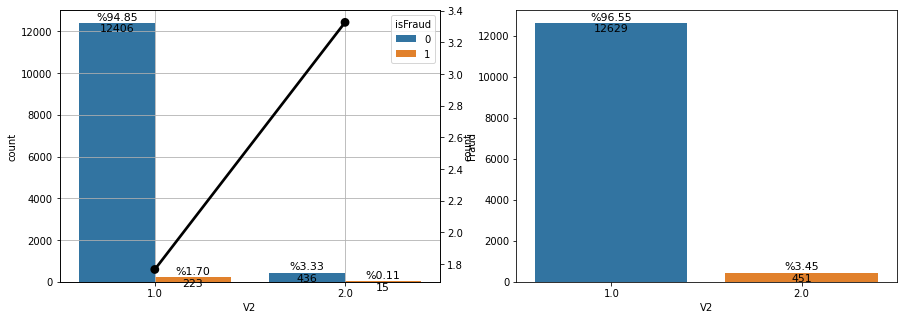

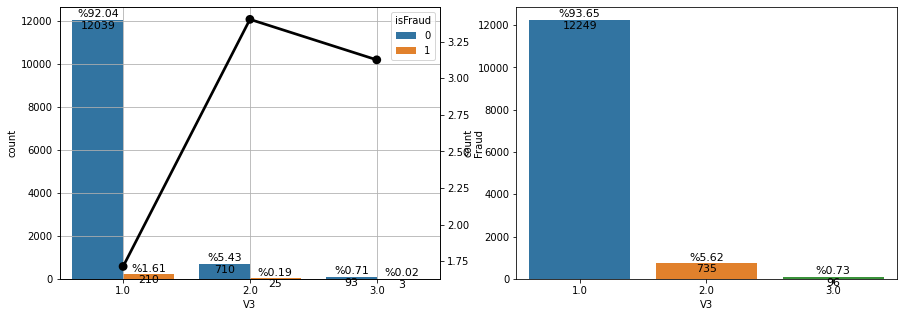

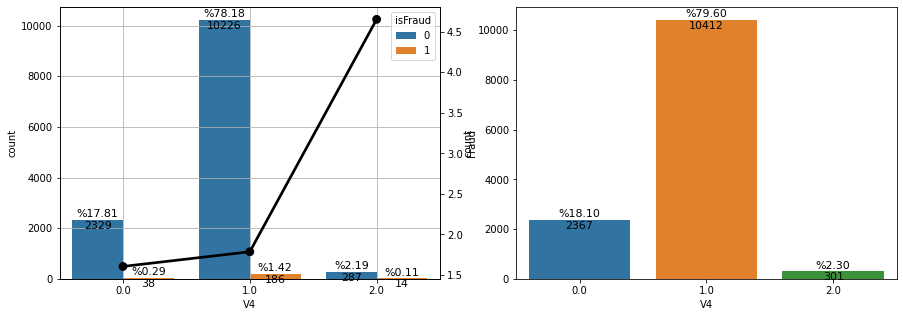

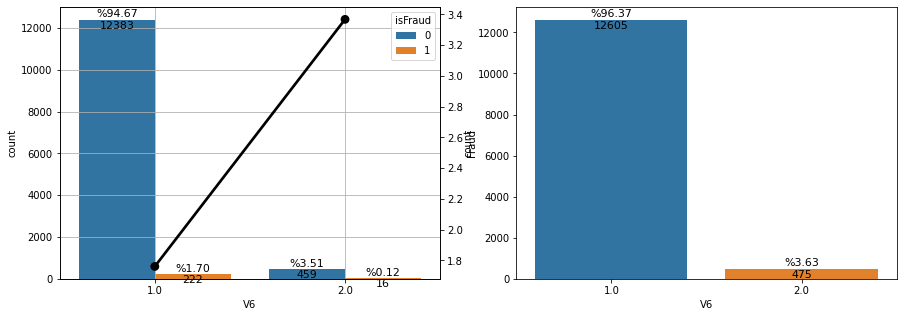

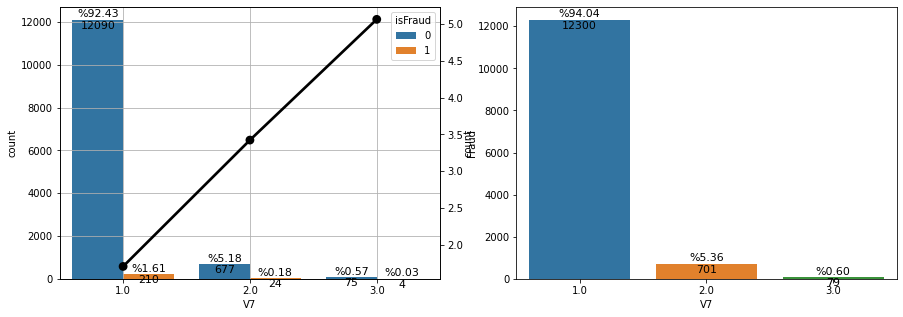

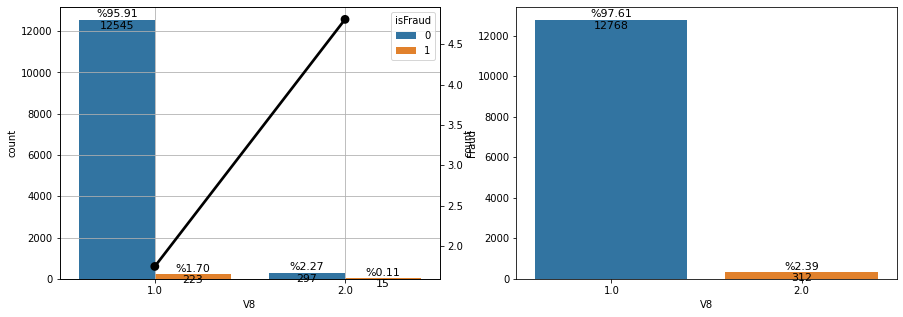

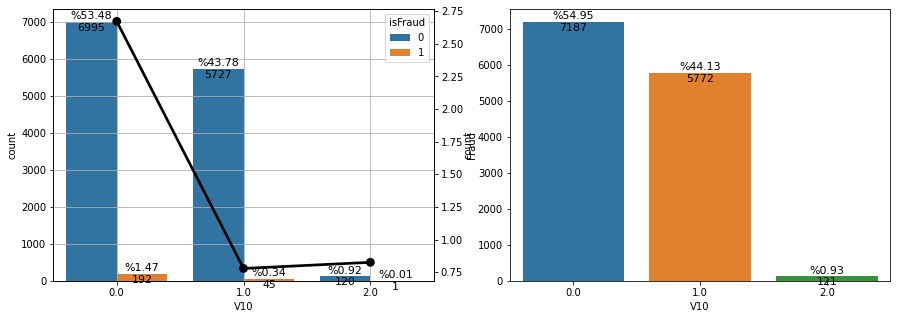

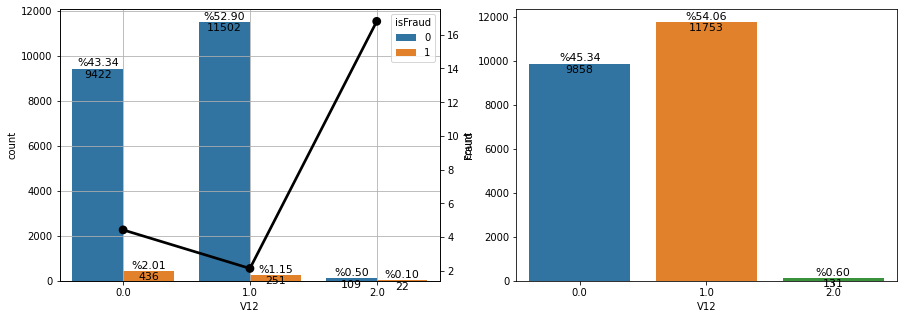

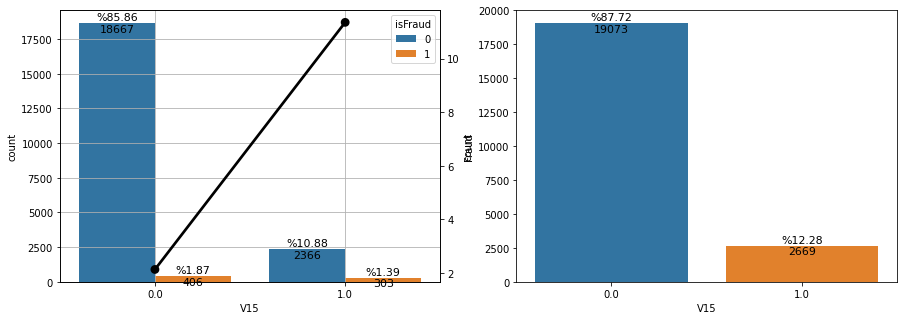

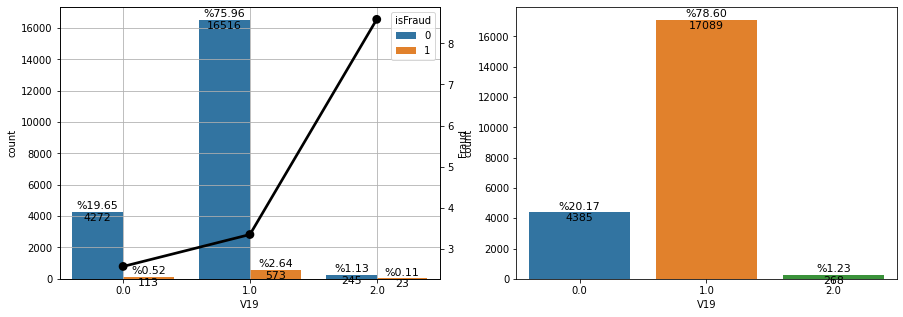

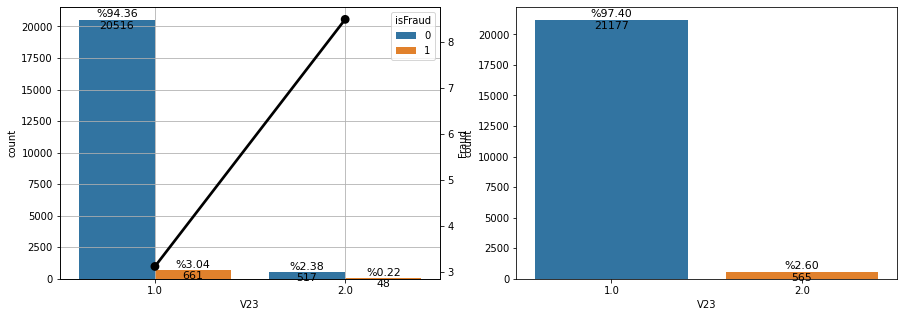

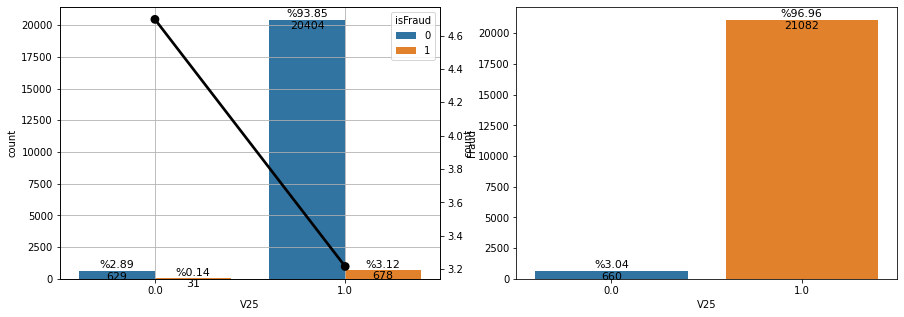

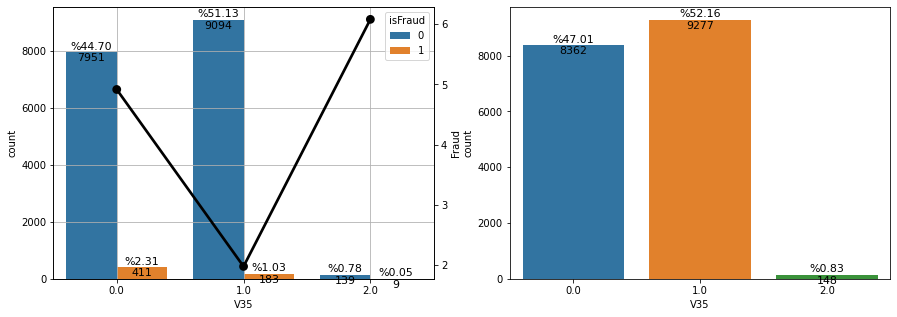

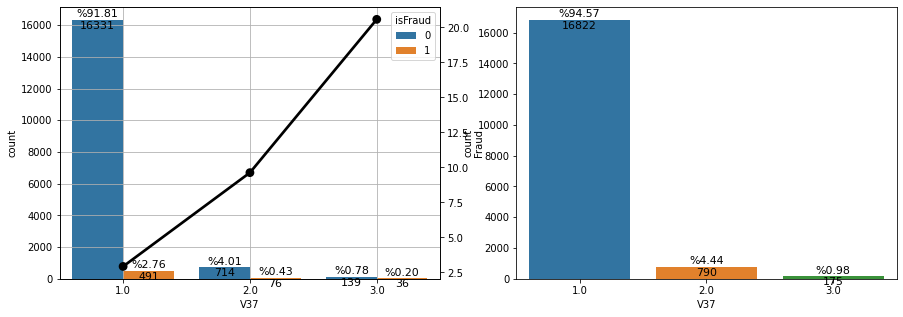

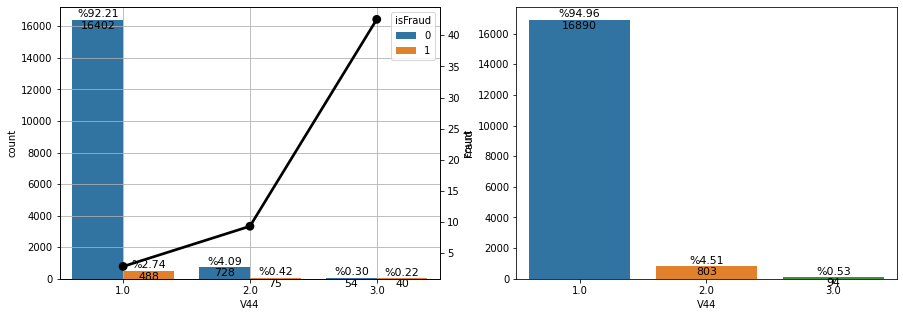

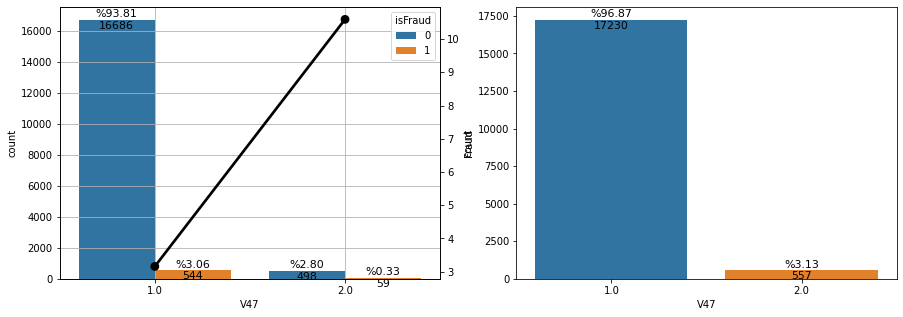

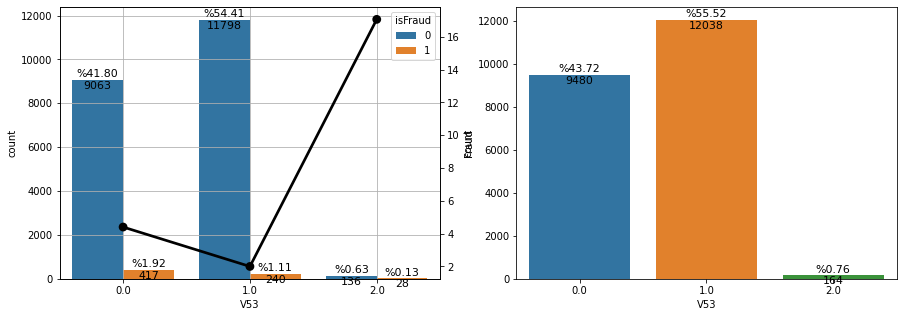

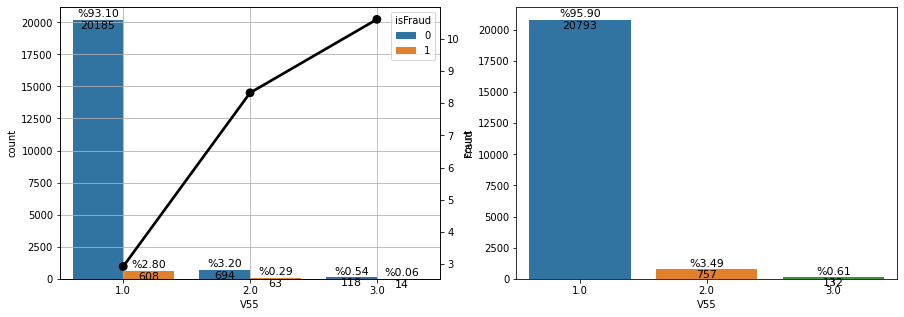

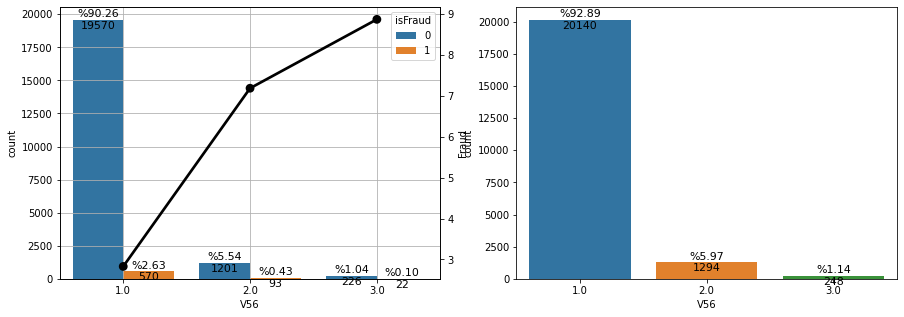

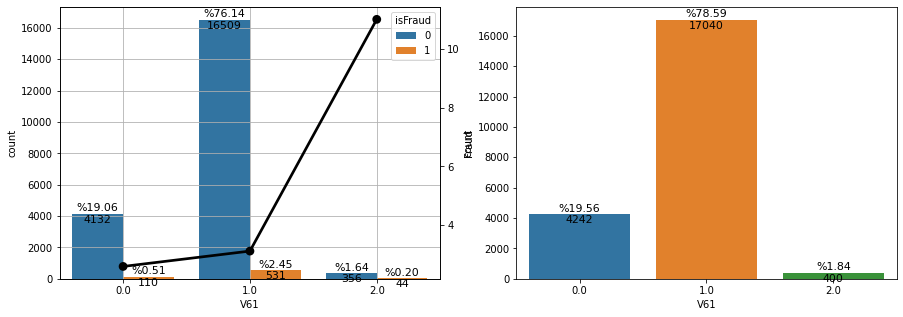

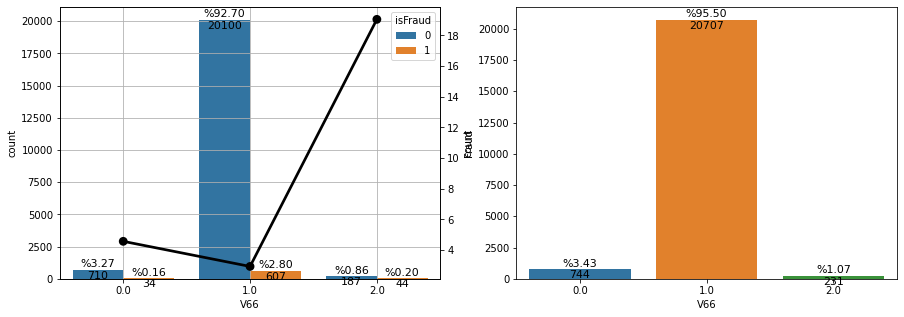

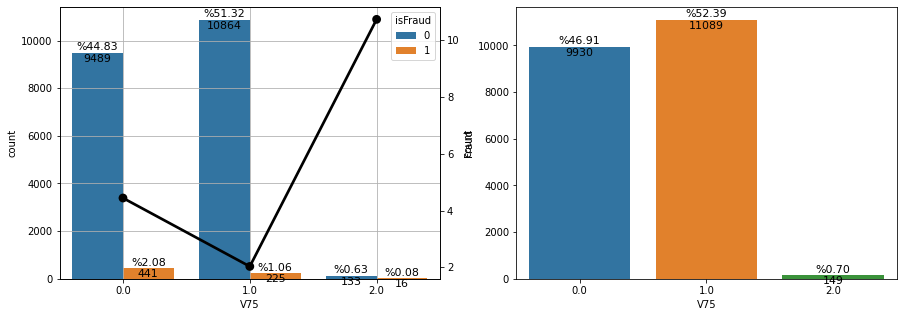

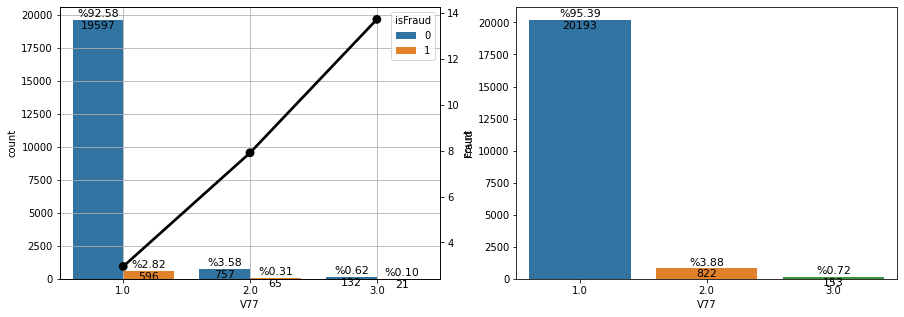

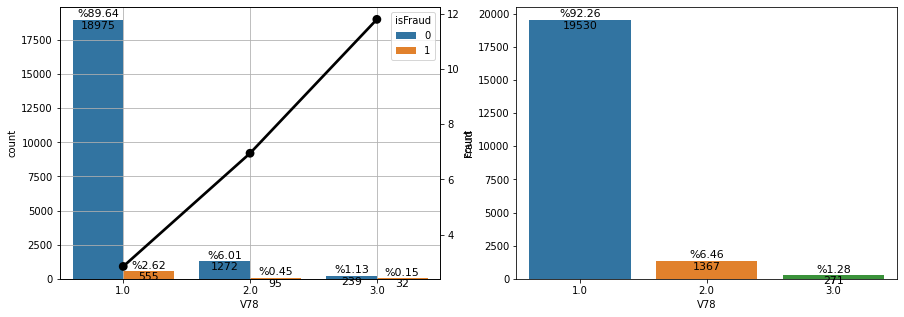

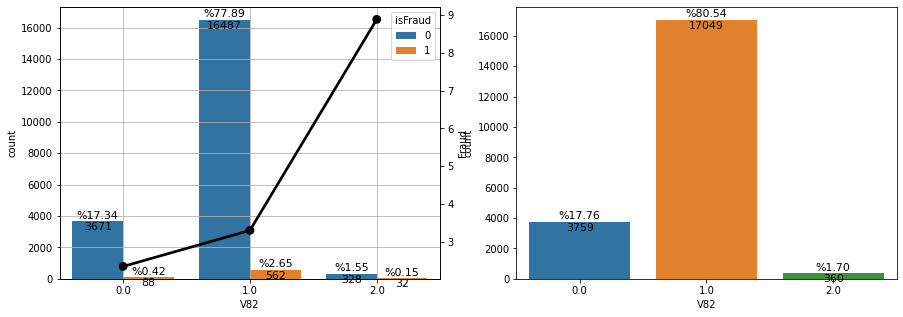

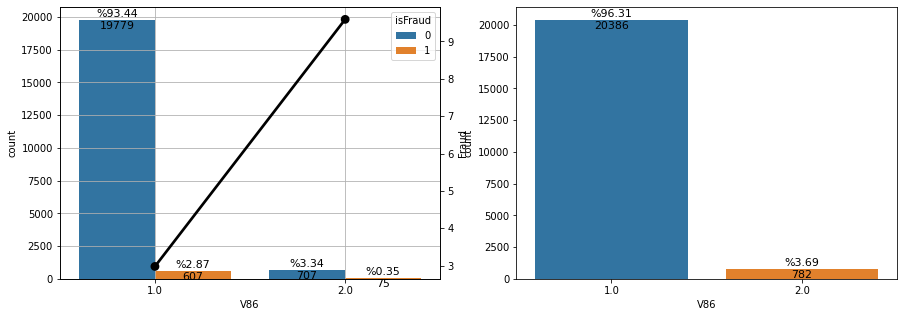

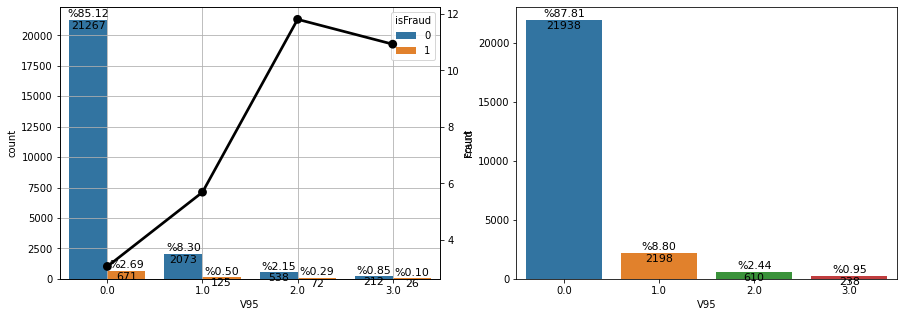

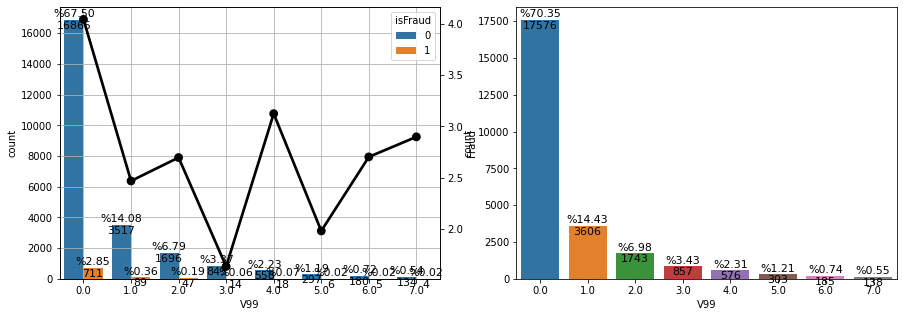

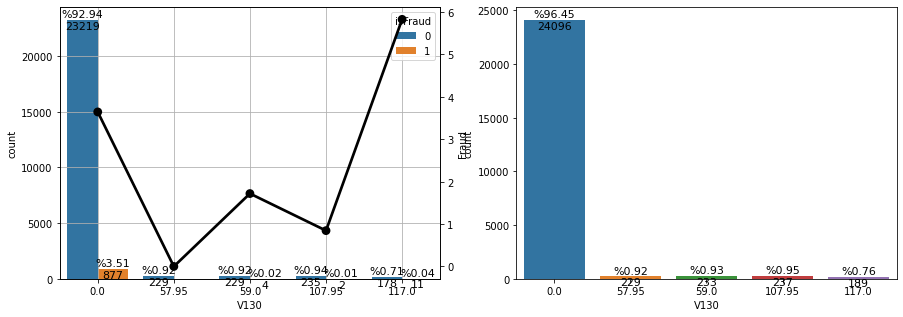

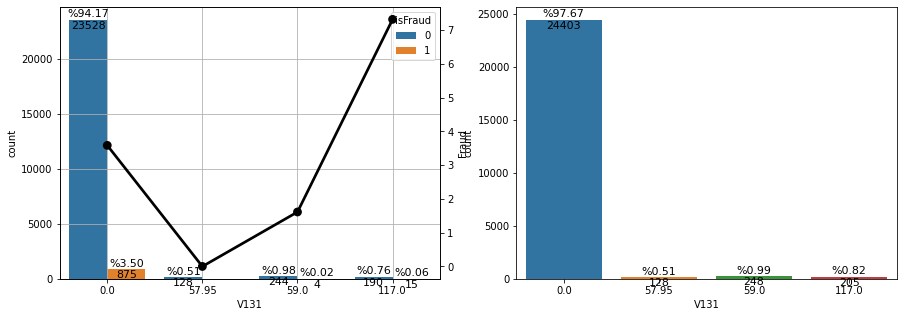

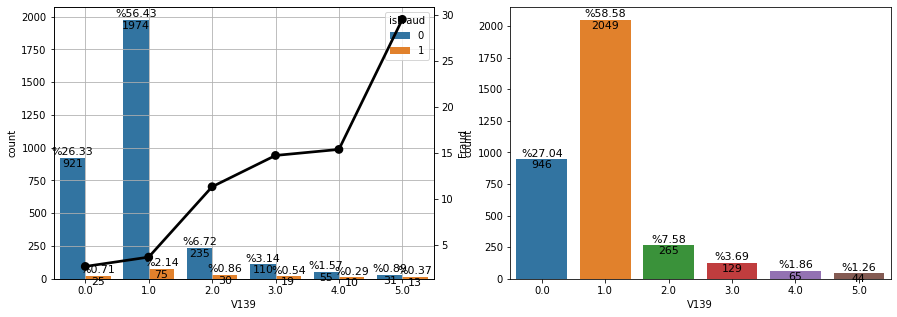

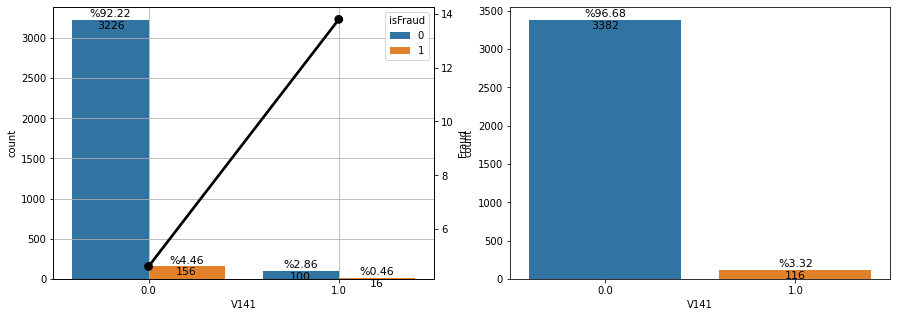

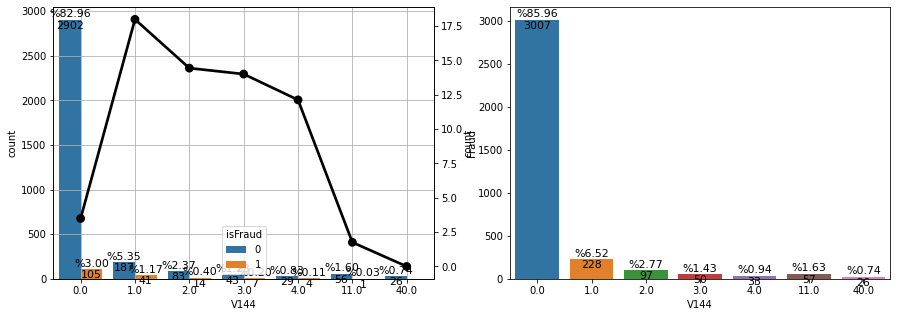

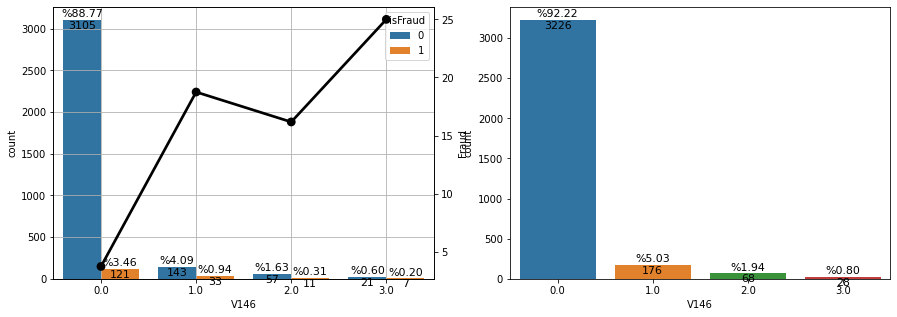

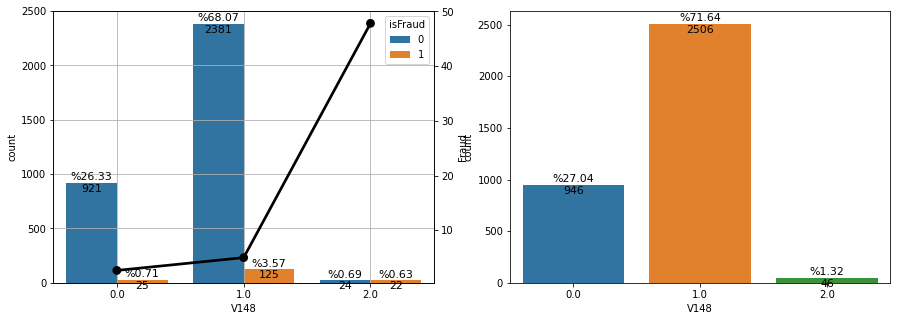

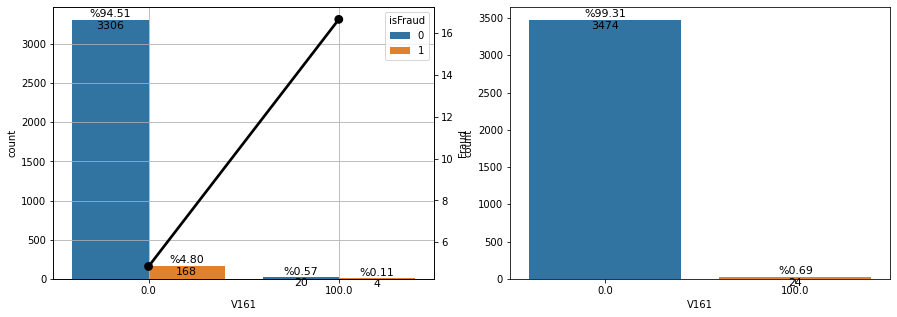

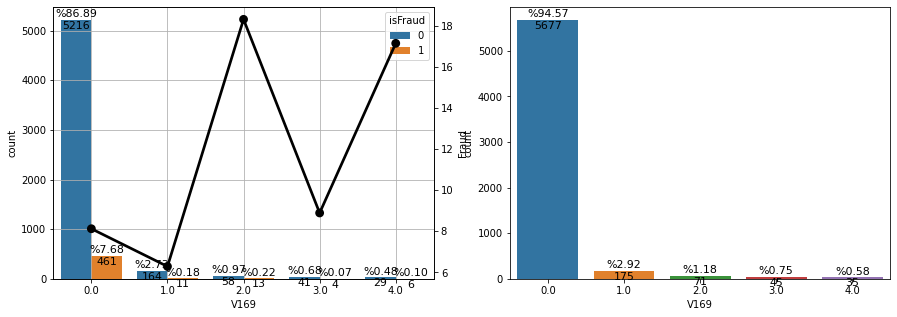

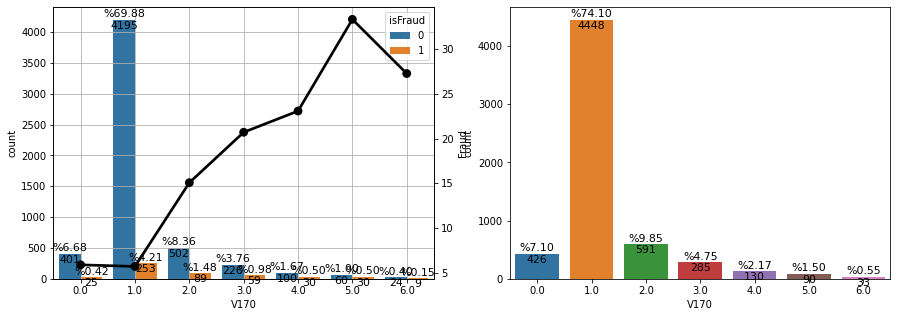

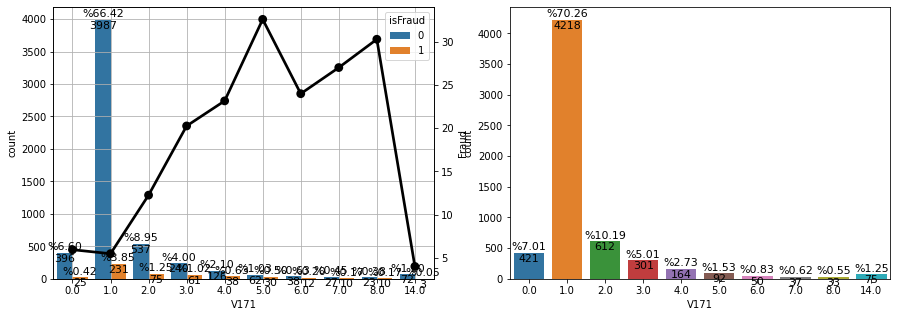

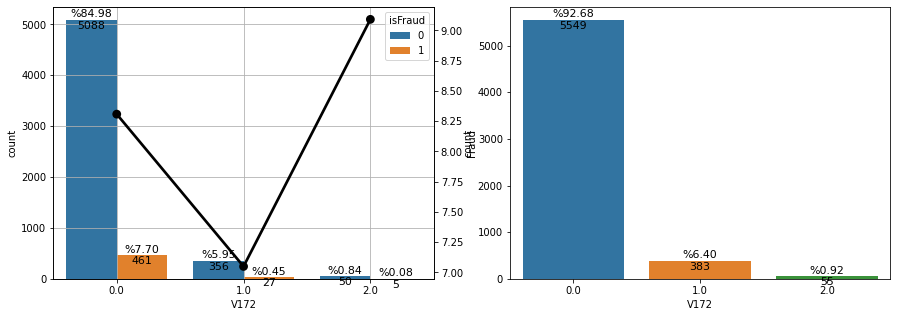

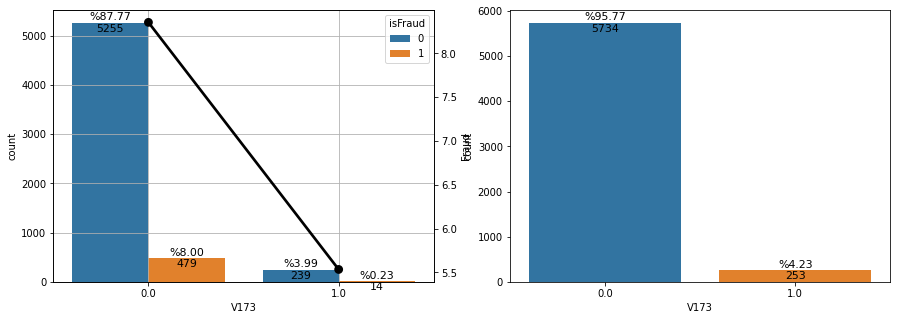

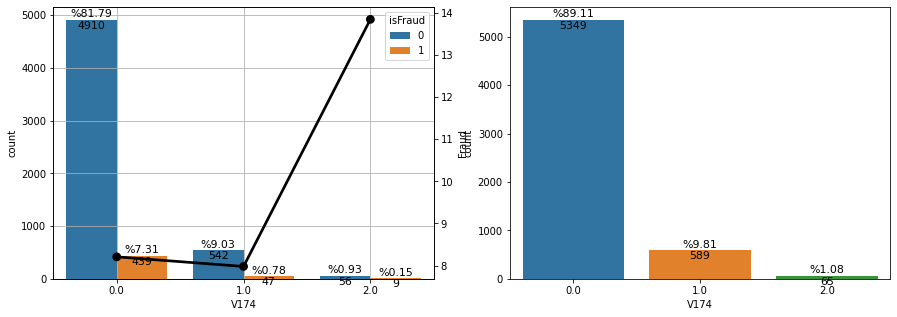

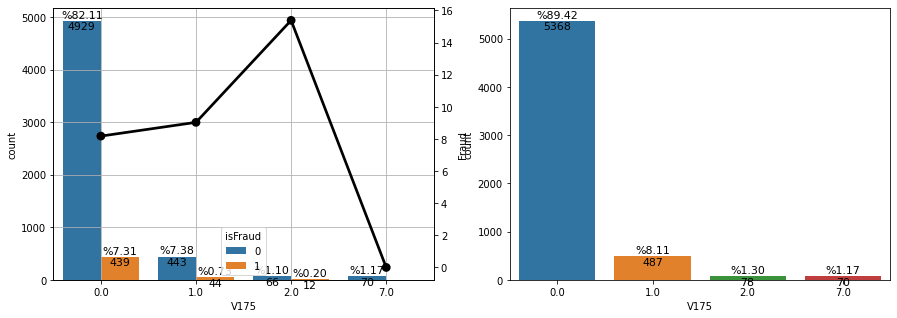

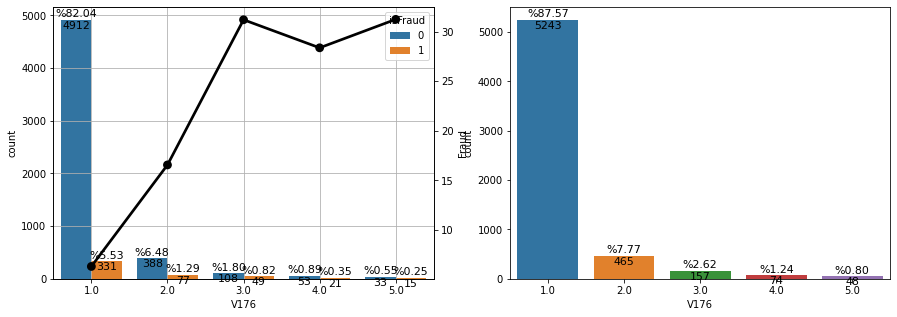

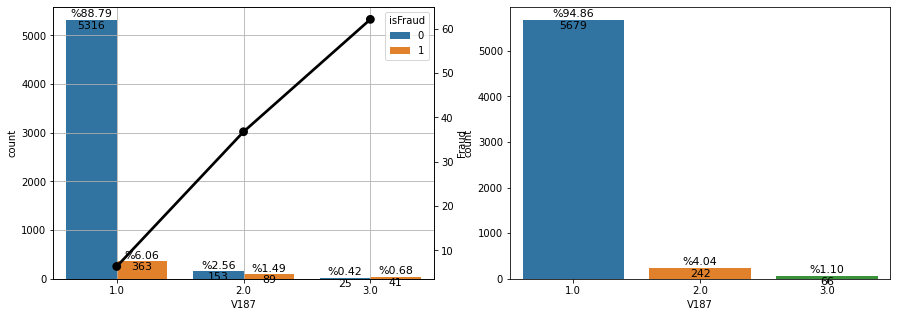

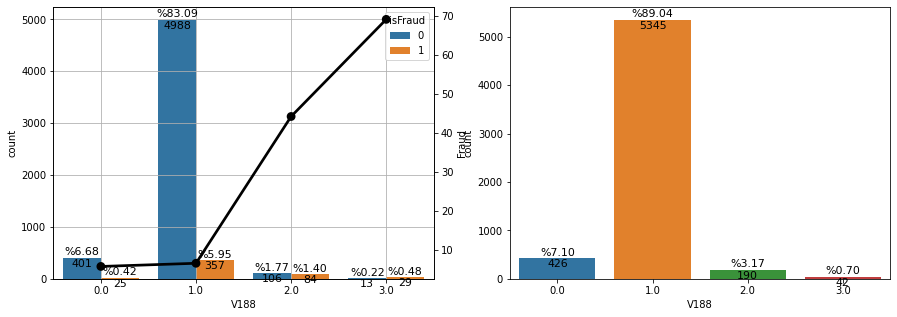

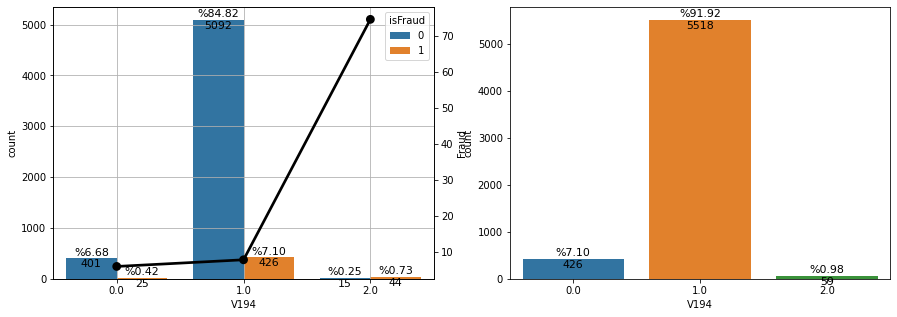

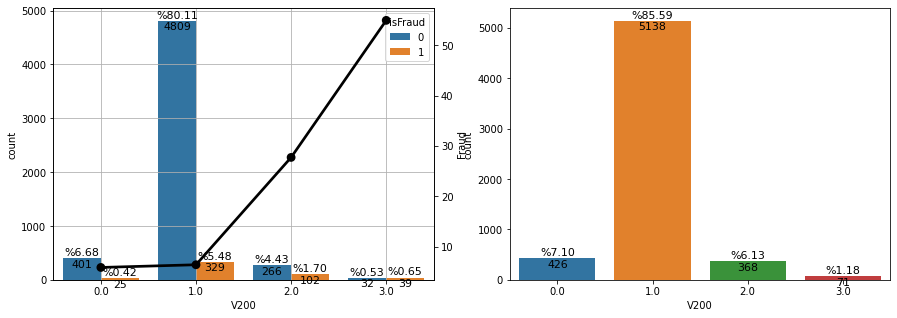

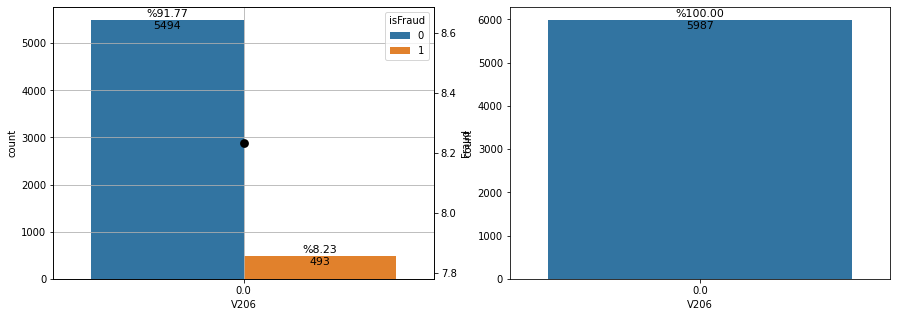

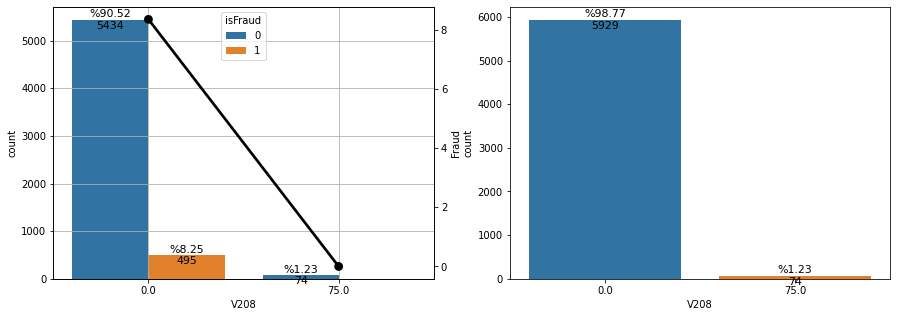

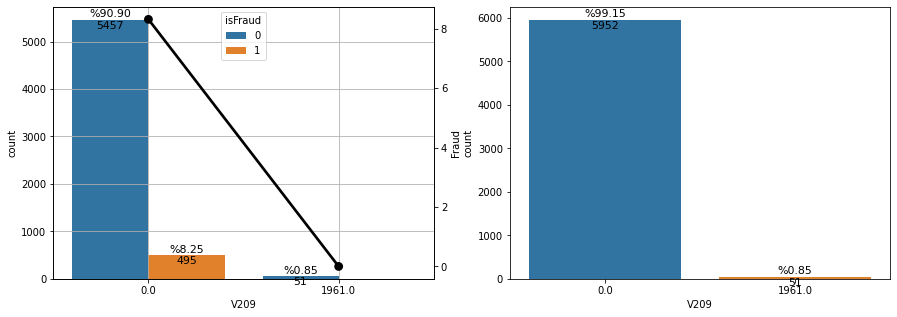

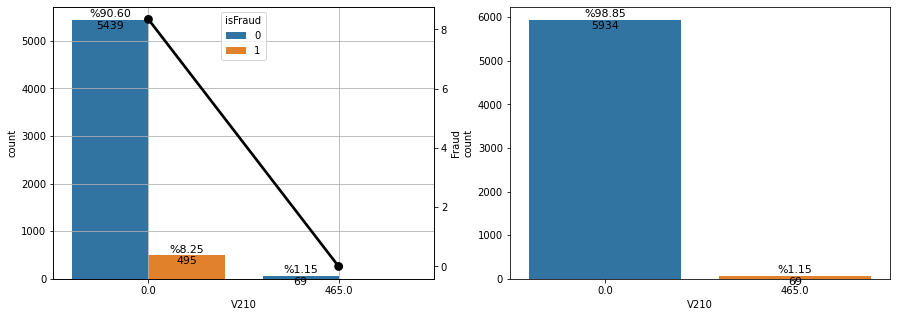

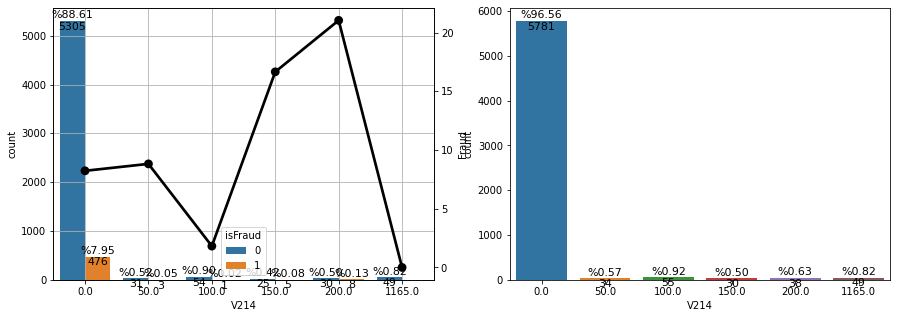

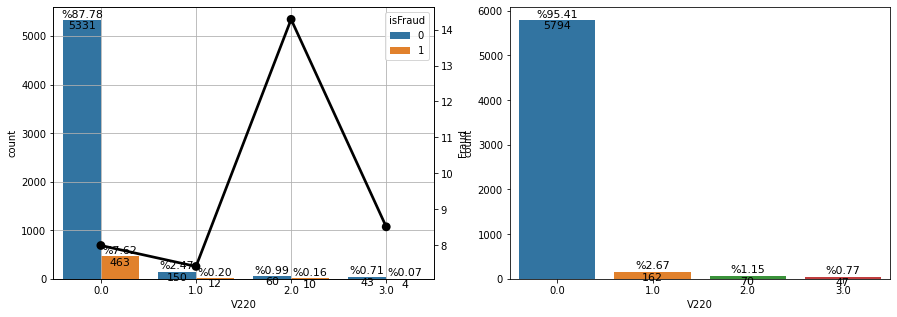

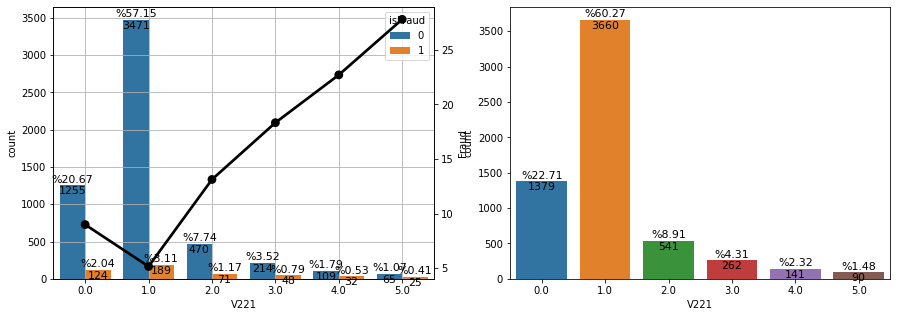

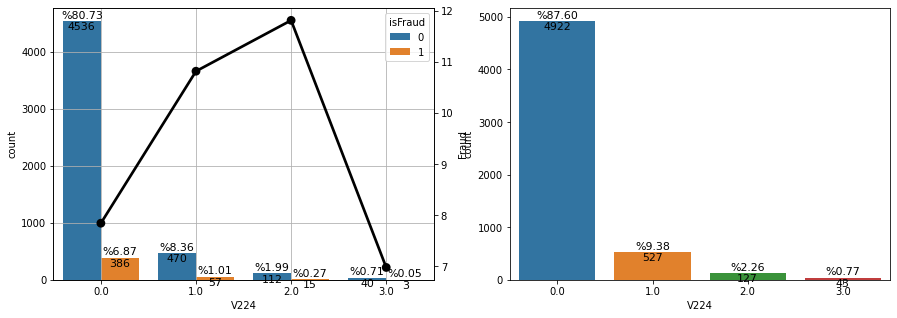

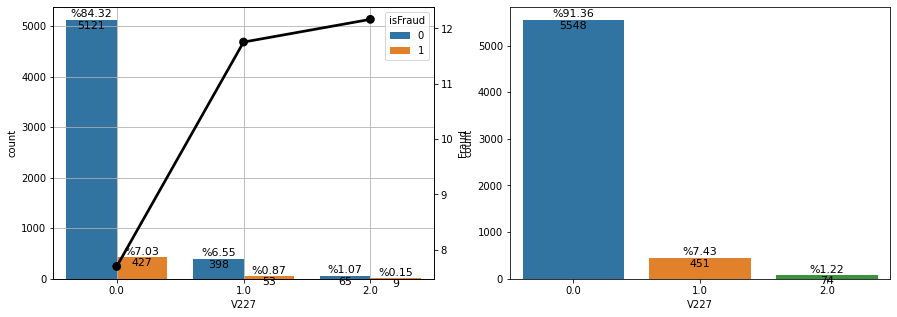

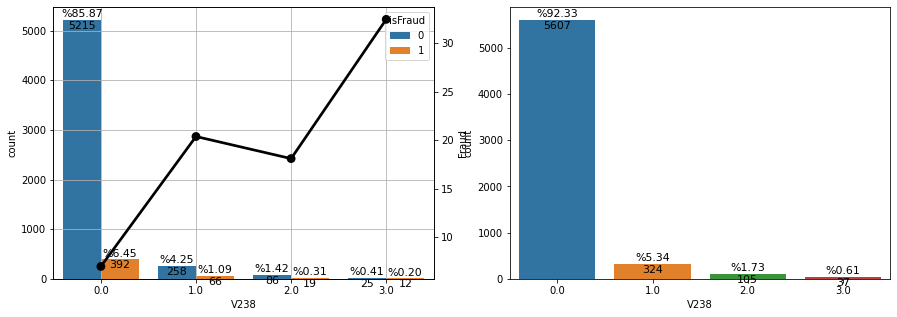

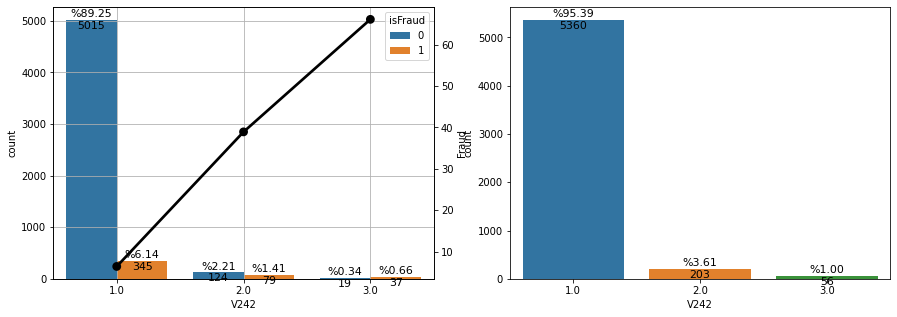

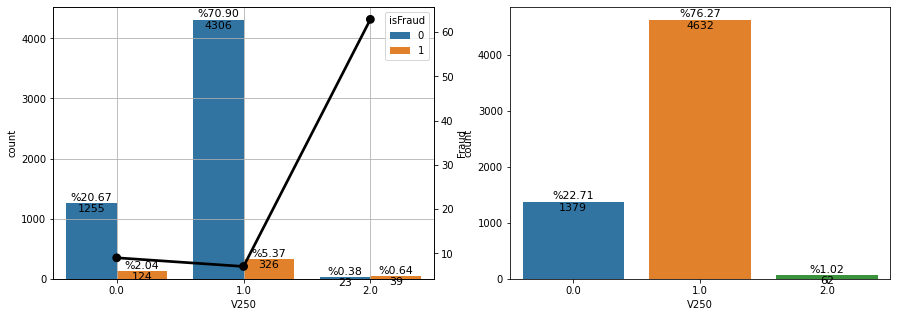

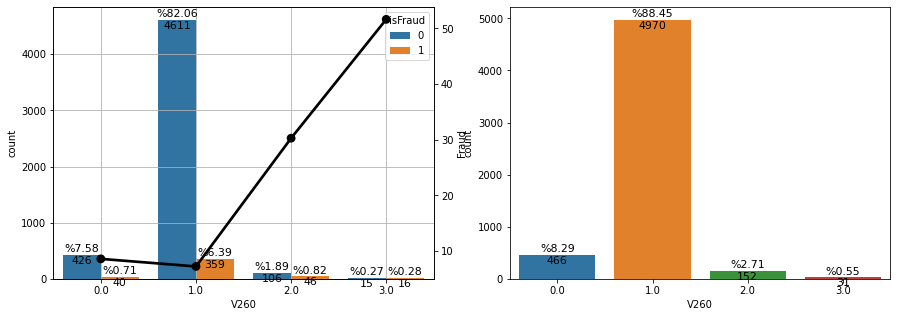

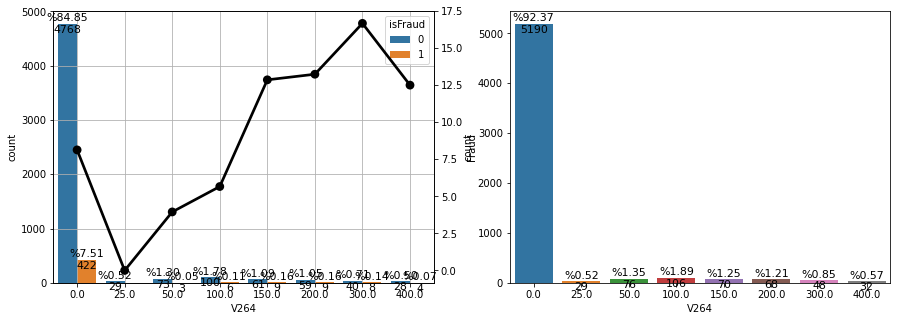

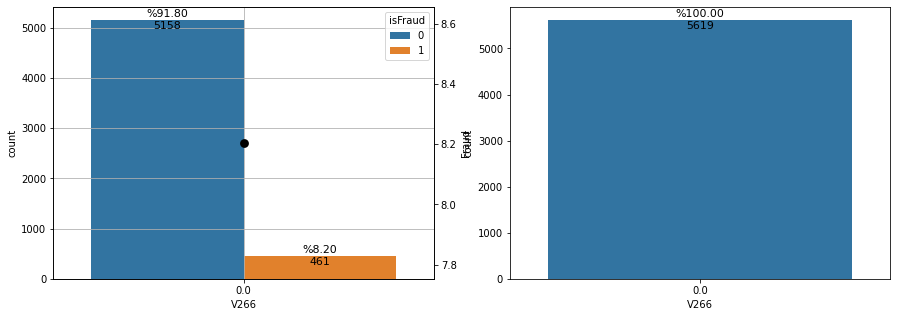

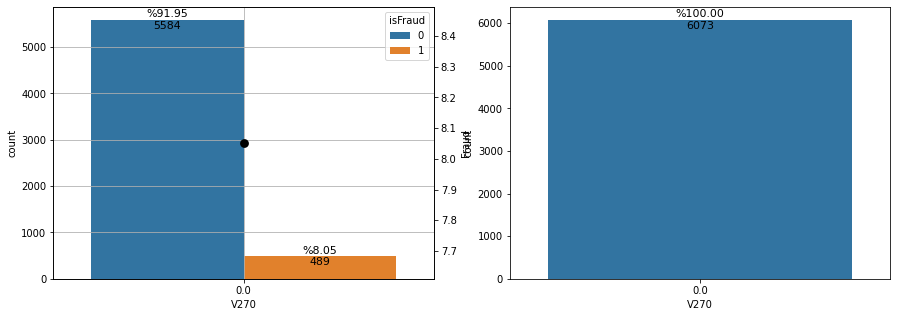

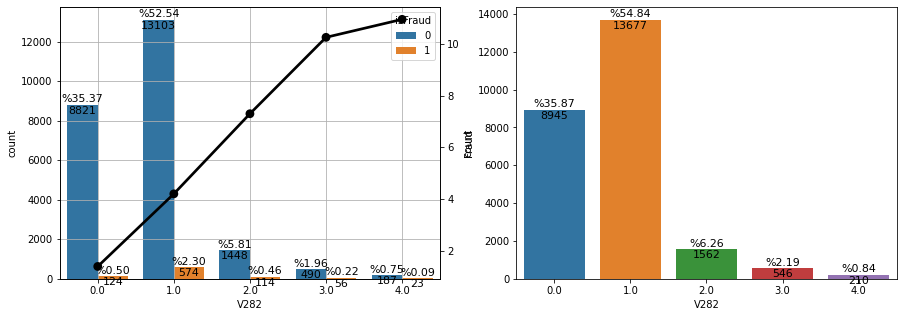

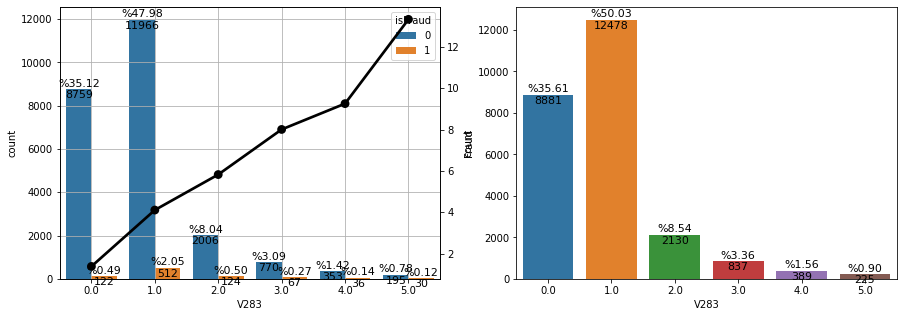

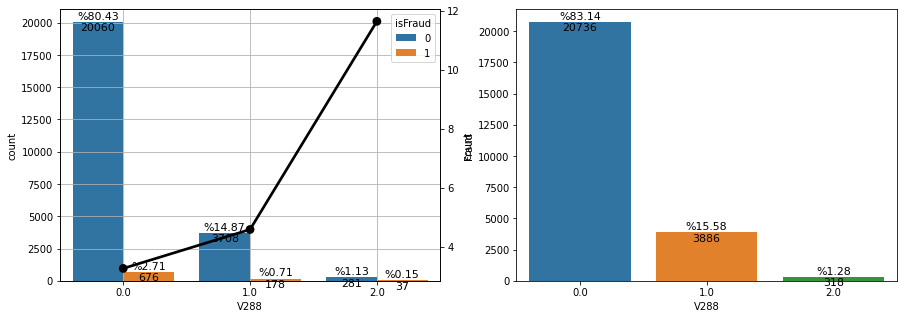

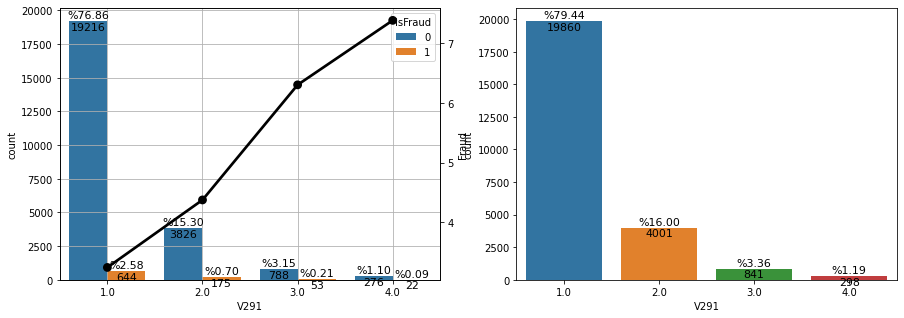

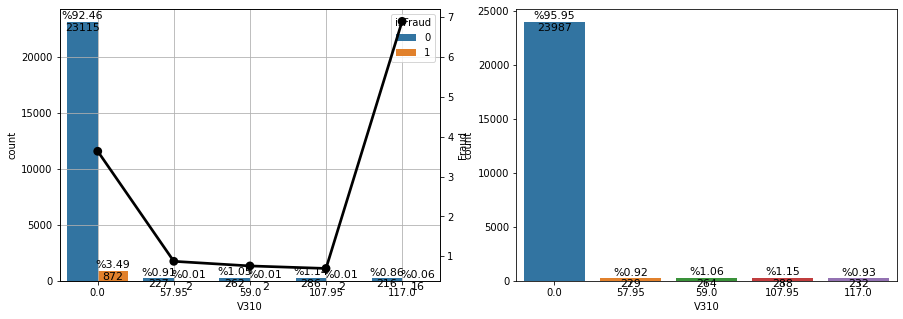

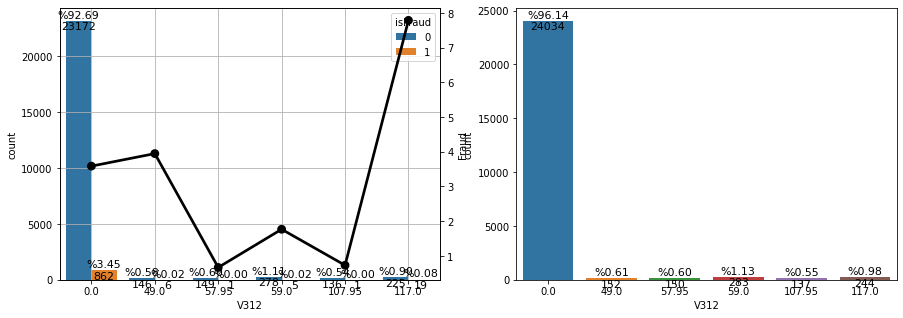

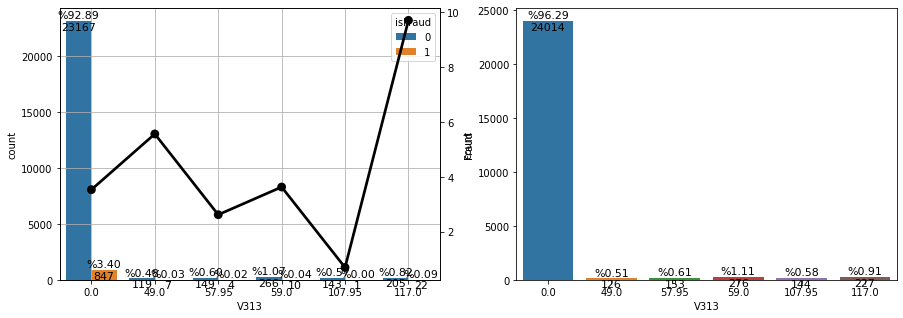

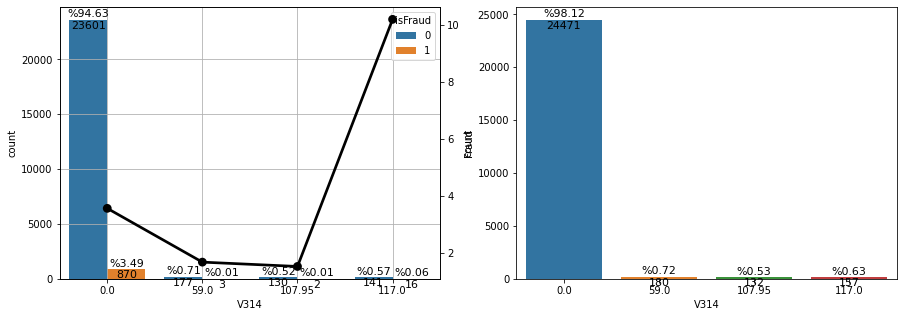

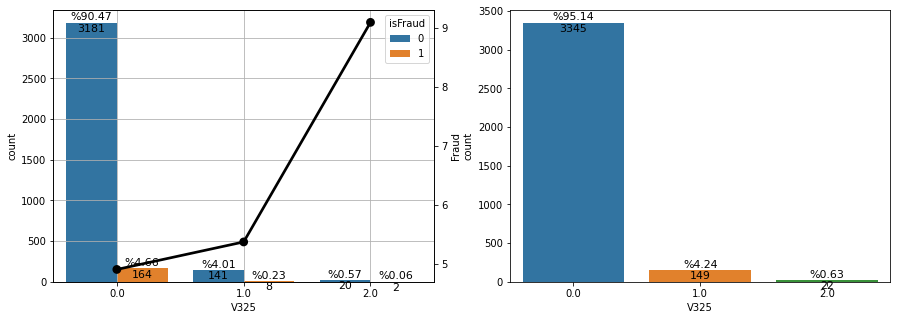

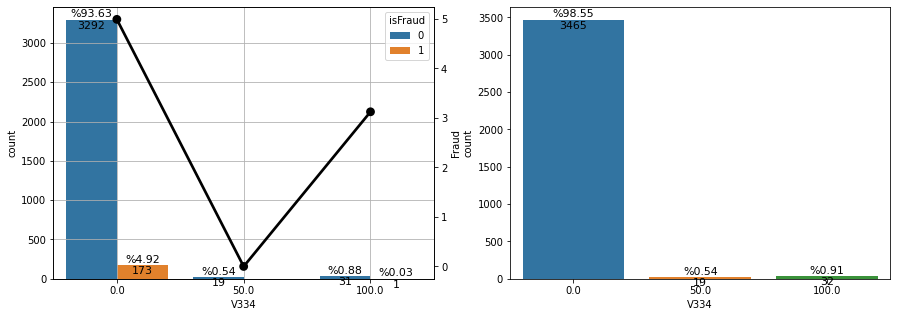

In [1208]:
for col in columns:
  df[col] = simplify_column(col, df=df, rate=0.005 )
  plot_col(col, df=df, figsize=(15,5))

> V206-266-270 have unique value. Reevaluate them with test data.

In [1209]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

In [1210]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [1211]:
# for col in columns:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [1212]:
# df.C1 = pd.Series( winsorize(df.C1, limits=(0, 0.1)))
# df.C1.describe()

In [1213]:
# ax = sns.boxplot(x='isFraud',y='C1', data=df)
# box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='C1');

In [1214]:
# df.C5 = pd.Series( winsorize(df.C5, limits=(0, 0.1)))
# df.C5.describe()

In [1215]:
# ax = sns.boxplot(x='isFraud',y='C5', data=df)
# box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='C5');

#### Plots

In [1216]:
# plot_cols(regex='V\d*', figsize=(30, 300), target='isFraud')

In [1217]:
# hist_countplot(regex='V\d*', figsize=(30, 200), nrow=25, ncolumn = 3)

In [1218]:
# box_countplot(regex='V\d*', figsize=(30, 200), nrow=25, ncolumn = 3)

### ProductCD

In [1219]:
column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



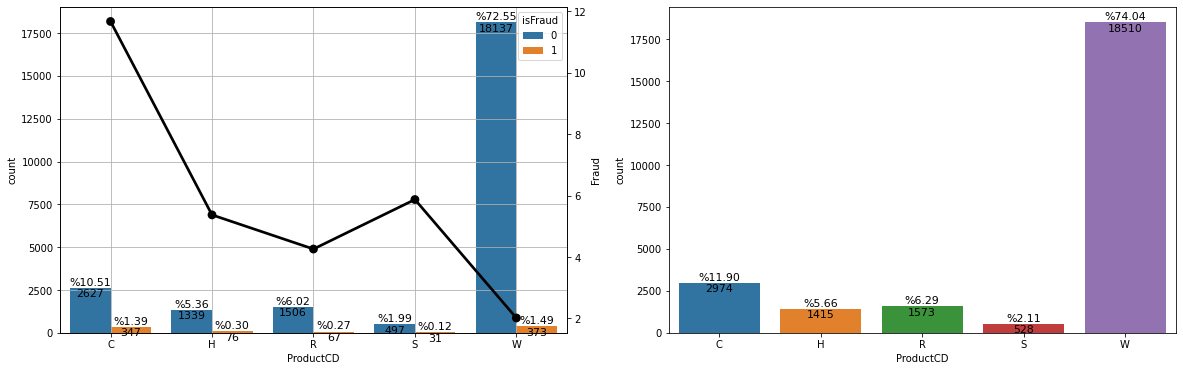

In [1220]:
plot_col('ProductCD')

### DeviceInfo

In [1221]:
column_details(regex='DeviceInfo', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 505, %79.85
['0PM92' '2PS64 Build/NRD90M' '5010G Build/MRA58K' '5010S Build/MRA58K'
 '5011A Build/NRD90M' '5012G Build/MRA58K' '5025G Build/LMY47I' '5054N'
 '5056A Build/MMB29M' '5080A Build/MRA58K' '6045I Build/LRX22G'
 '8050G Build/LMY47I' '8062 Build/MRA58K' 'A0001 Build/MHC19Q' 'A577VL'
 'ALCATEL' 'ALE-L21 Build/HuaweiALE-L21' 'ALE-L23 Build/HuaweiALE-L23'
 'ASUS_X015D Build/NRD90M' 'ASUS_Z017D' 'Android 4.4.2' 'Android 5.1'
 'Android 6.0' 'Aquaris' 'Aquaris U Plus Build/NMF26F' 'Archos'
 'BAC-L03 Build/HUAWEIBAC-L03' 'BLADE V8 Build/NRD90M'
 'BLADE V8 SE Build/NRD90M' 'BLN-L21 Build/HONORBLN-L21'
 'BLU ENERGY X PLUS Build/LRX21M' 'Blade A475 Build/LMY47D'
 'Blade A510 Build/MRA58K' 'Blade L2 Plus Build/KOT49H'
 'Blade L3 Build/KOT49H' 'Blade V580 Build/LMY47D'
 'Blade V6 Max Build/MRA58K' 'Blade V6 Plus Build/MRA58K' 'Build/KOT49H'
 'Build/OPM1.171019.011' 'Build/OPR6.170623.013' 'C2104' 'C6603

In [1222]:
df.DeviceInfo.replace(regex={r'.*SAMSUNG.*': 'samsung',
                        '.*SM.*': 'samsung',
                        '^SC.*': 'samsung',
                        '.*Lenovo.*': 'lenovo',
                        '^V.*': 'lg',
                        '.*LG.*': 'lg',
                        '.*HUAWEI.*':'huawei',
                        '.*Huawei.*':'huawei',
                        '.*Moto.*':'motorola',
                        '.*moto.*':'motorola',
                        '.*HTC.*':'htc',
                        '.*Redmi.*':'redmi',
                        '.*Blade.*':'blade',
                        '.*BLADE.*':'blade',    
                        '.*Nexus.*':'nexus',
                        '.*GT.*':'gt',
                        '.*Pixel.*':'pixel',
                        '.*Hisense.*':'hisense',
                        '.*ALCATEL.*':'alcatel',
                        '.*ASUS.*':'asus',
                        '.*Ilium.*':'ilium',
                        '.*iris.*':'iris',
                        '.*Aquaris.*':'aquaris',
                        '.*Archos.*':'archos',
                        '.*Linux.*':'linux',
                        '.*Android.*':'android',
                        '.*Microsoft.*':'microsoft',
                        '.*MacOS.*':'macOS',
                        '.*Trident.*':'trident',
                        '.*rv.*':'rv',
                        '.*XT.*':'xt',
                        '.*Windows.*':'windows',
                        '.*TA.*':'ta',
                        '.*iOS.*':'ios',
                        '.*verykool.*':'verykool',
                        '.*0PM92.*':'htc',
                        '.*2PS64.*':'htc',
                        '.*HONOR.*':'honor',
                        '.*EGO.*':'other',
                         '^50.*':'alcatel',
                         '^60.*':'alcatel',
                         '^80.*':'alcatel',
                         '^A.*':'alcatel',
                         '^[CEFG].*':'sony',
                         '^SG.*':'sony',
                         '^M4.*':'m4',
                         '.*MOT.*':'morotola',
                         '^Mi.*':'xiaomi',
                         '^MI.*':'xiaomi',
                         '^Z.*':'zte',
                         '^K.*':'android'}, inplace=True)


df['DeviceInfo'] = simplify_column('DeviceInfo', df=df, rate=0.005, value='other')
# df.DeviceInfo.replace(df.DeviceInfo.value_counts(dropna=False)[df.DeviceInfo.value_counts(dropna=False, normalize=True)<0.005].index,'other', inplace= True)
df.DeviceInfo.value_counts(dropna=False)


NaN         19962
windows      2105
ios           816
macOS         502
samsung       500
trident       326
other         217
rv            177
motorola      130
lg            108
huawei         93
sony           36
htc            28
Name: DeviceInfo, dtype: int64

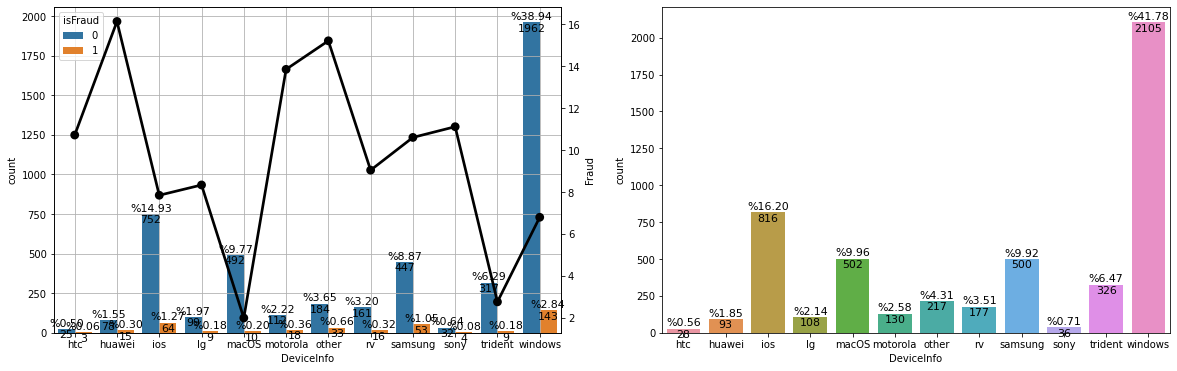

In [1223]:
plot_col('DeviceInfo', df=df)

### DeviceType

In [1224]:
column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %75.8
['desktop' 'mobile' nan]



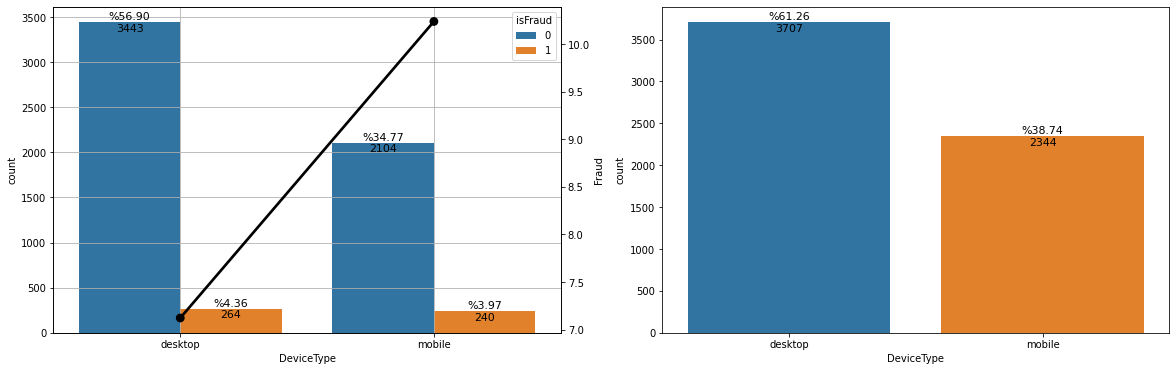

In [1225]:
plot_col('DeviceType', df=df)

### R_emaildomain

In [1226]:
column_details(regex='R_emaildomain', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 53, %76.39
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'charter.net' 'comcast.net' 'cox.net' 'earthlink.net'
 'embarqmail.com' 'frontier.com' 'frontiernet.net' 'gmail' 'gmail.com'
 'gmx.de' 'hotmail.co.uk' 'hotmail.com' 'hotmail.de' 'hotmail.es'
 'hotmail.fr' 'icloud.com' 'juno.com' 'live.com' 'live.com.mx' 'live.fr'
 'mac.com' 'mail.com' 'me.com' 'msn.com' 'netzero.com' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es'
 'yahoo.fr' 'ymail.com' nan]



In [1227]:
df.R_emaildomain =df.R_emaildomain.str.split('.').str[0]

In [1228]:
df.R_emaildomain = simplify_column('R_emaildomain', df=df, rate=0.005, value='other')

In [1229]:
# df.R_emaildomain.replace(df.R_emaildomain.value_counts(dropna=False)[df.R_emaildomain.value_counts(dropna=False,normalize=True)<0.005].index,'other', inplace= True)
df.R_emaildomain.value_counts(dropna=False)

NaN          19097
gmail         2452
hotmail       1234
anonymous      856
yahoo          593
other          215
aol            172
outlook        121
comcast         82
icloud          72
live            63
msn             43
Name: R_emaildomain, dtype: int64

In [1230]:
df.R_emaildomain.describe()

count      5903
unique       11
top       gmail
freq       2452
Name: R_emaildomain, dtype: object

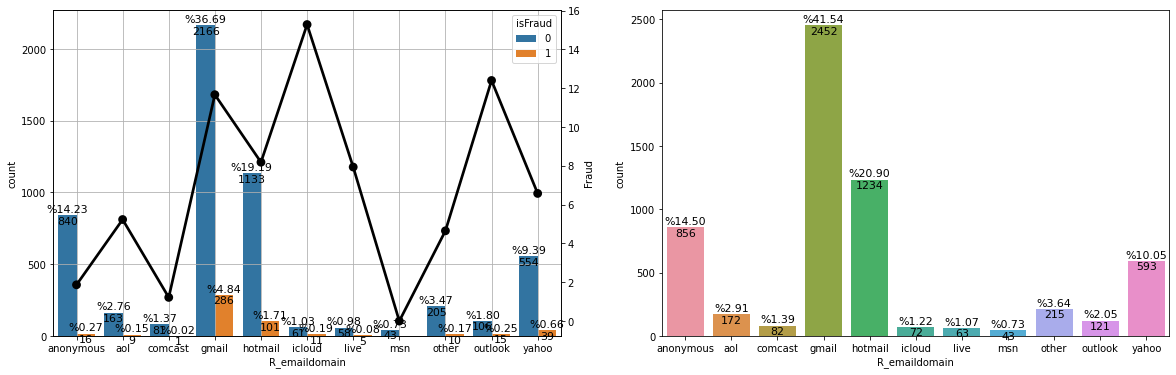

In [1231]:
plot_col('R_emaildomain', df=df)

### P_emaildomain

In [1232]:
column_details(regex='P_emaildomain', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 57, %16.28
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es'
 'yahoo.fr' 'ymail.com' nan]



In [1233]:
df.P_emaildomain =df.P_emaildomain.str.split('.').str[0]

In [1234]:
df['P_emaildomain'] = simplify_column('P_emaildomain', df=df, rate=0.005, value='other')
# df.P_emaildomain.replace(df.P_emaildomain.value_counts(dropna=False)[df.P_emaildomain.value_counts(dropna=False, normalize=True)<0.005].index,'other', inplace= True)
df.P_emaildomain.value_counts(dropna=False)

gmail        9669
yahoo        4366
NaN          4069
hotmail      1957
anonymous    1541
aol          1205
other         602
comcast       326
icloud        282
outlook       247
msn           170
live          166
att           159
sbcglobal     123
verizon       118
Name: P_emaildomain, dtype: int64

In [1235]:
df.P_emaildomain.describe()

count     20931
unique       14
top       gmail
freq       9669
Name: P_emaildomain, dtype: object

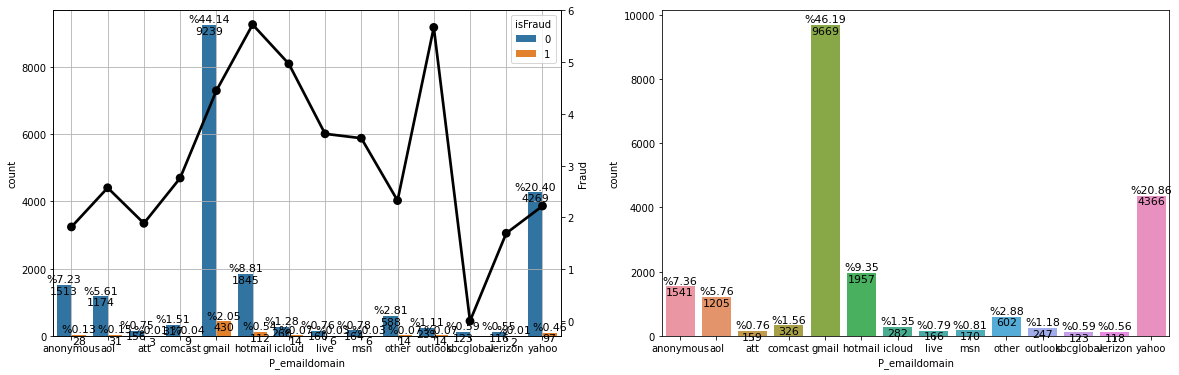

In [1236]:
plot_col('P_emaildomain', df=df)

### Transaction_hour

In [1237]:
column_details(regex='Transaction_hour', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

Transaction_hour:  float64, 24, %0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]



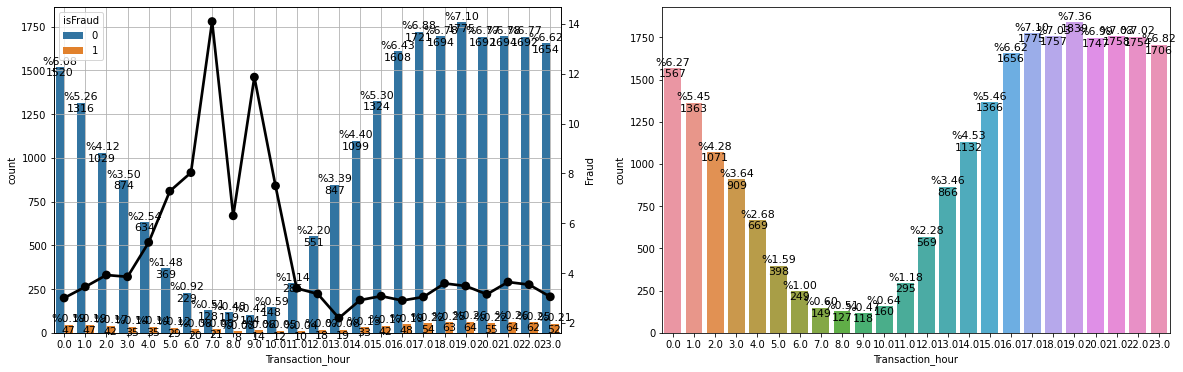

In [1238]:
plot_col('Transaction_hour', df=df)

### Transaction_day_of_week

In [1239]:
column_details(regex='Transaction_day_of_week', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

Transaction_day_of_week:  float64, 7, %0.0
[0. 1. 2. 3. 4. 5. 6.]



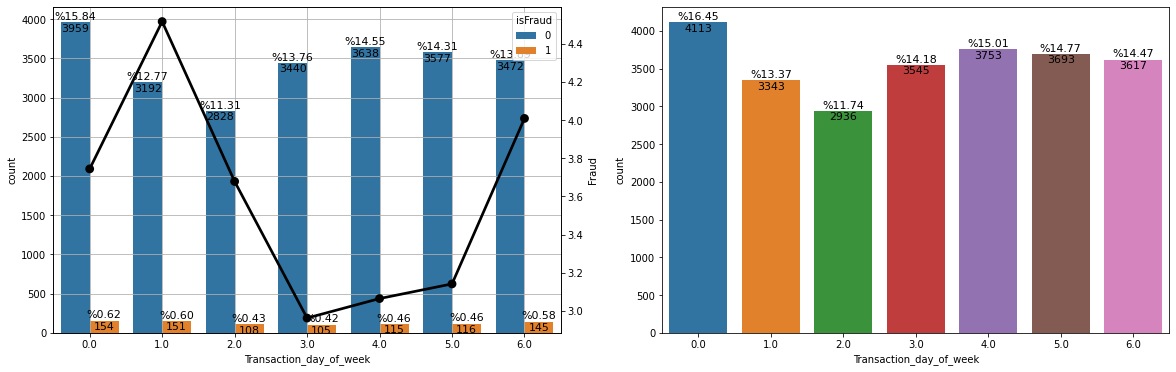

In [1240]:
plot_col('Transaction_day_of_week', df=df)

### TransactionDT

In [1241]:
df['TransactionDT']= data.TransactionDT.copy()

In [1242]:
column_details(regex='TransactionDT', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionDT:  int64, 24978, %0.0
[   86469    86522    86998 ... 15809412 15809554 15809796]



In [1243]:
(df['TransactionDT']//(3600*24)).describe()

count    25000.000000
mean        84.609520
std         53.252432
min          1.000000
25%         35.000000
50%         84.000000
75%        129.000000
max        182.000000
Name: TransactionDT, dtype: float64

In [1244]:
df[df.isFraud==1]['TransactionAmt'].median(), \
df[df.isFraud==0]['TransactionAmt'].median()

(77.0, 67.95)

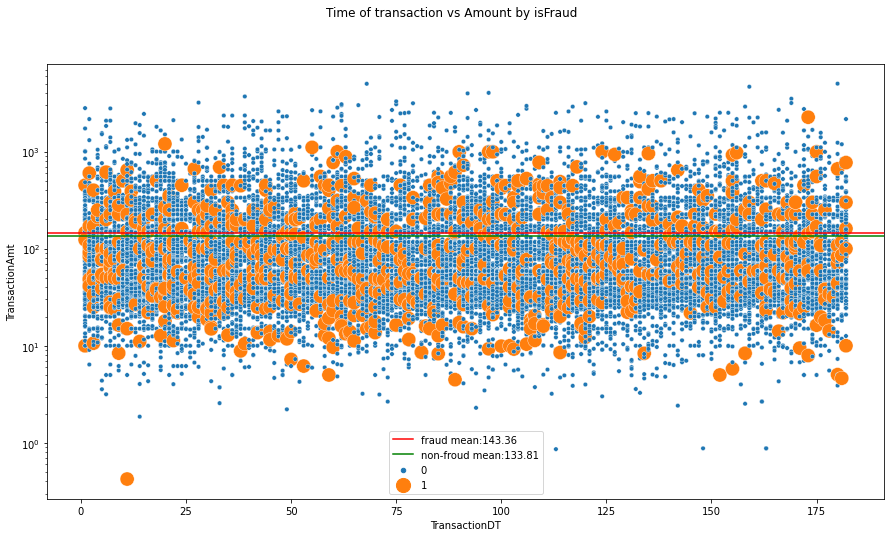

In [1245]:
plt.figure(figsize=(15,8))
plt.suptitle('Time of transaction vs Amount by isFraud')
fraud_mean, nonfraud_mean = df[df.isFraud==1]['TransactionAmt'].mean(), df[df.isFraud==0]['TransactionAmt'].mean()
sns.scatterplot(x=df['TransactionDT']//(3600*24), y=df['TransactionAmt'], data=df, hue='isFraud', size="isFraud", sizes=(200, 20))
plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
plt.axhline(y=nonfraud_mean, color='green',label=f'non-froud mean:{round(nonfraud_mean,2)}')
plt.legend()
plt.yscale('log')
plt.show()

In [1246]:
df = df.drop('TransactionDT',axis=1)

### TransactionAmt

In [1247]:
column_details(regex='TransactionAmt', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionAmt:  float64, 3374, %0.0
[4.24000e-01 8.61000e-01 8.78000e-01 ... 4.65292e+03 4.98997e+03
 5.00182e+03]



In [1248]:
df.TransactionAmt.describe()

count    25000.000000
mean       134.149847
std        228.828829
min          0.424000
25%         43.950000
50%         67.950000
75%        125.000000
max       5001.820000
Name: TransactionAmt, dtype: float64

#### Handling Outliers

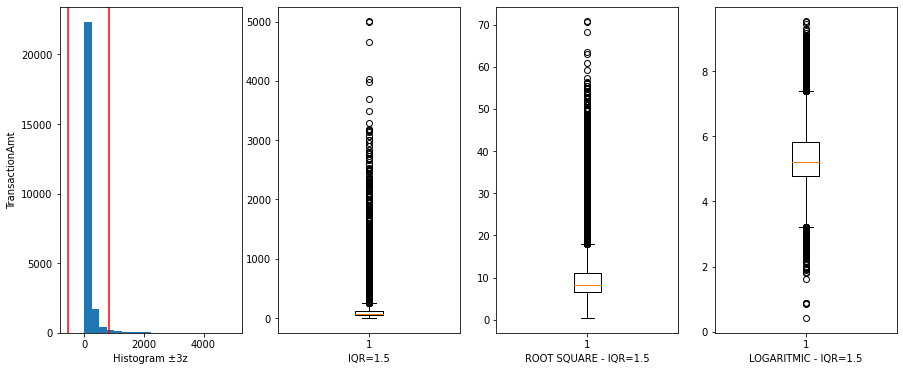

In [1249]:
col_plot(df, 'TransactionAmt')

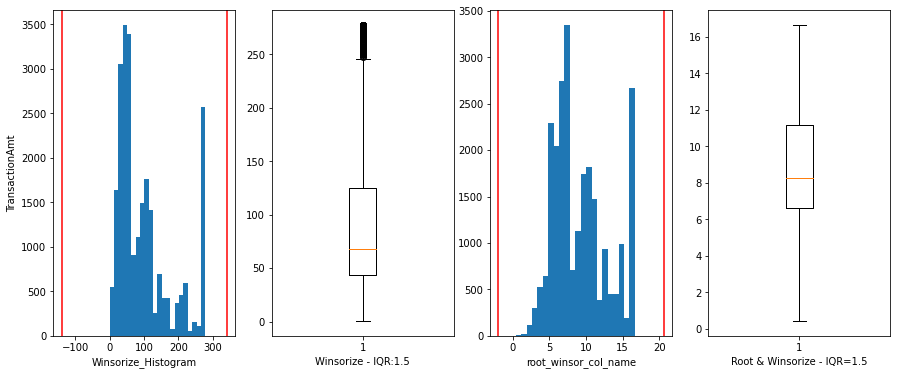

In [1250]:
plot_winsorize(df,'TransactionAmt')

In [1251]:
df.TransactionAmt = pd.Series( winsorize(np.sqrt(df.TransactionAmt), limits=(0, 0.1)))
df.TransactionAmt.describe()

count    25000.000000
mean         9.342184
std          3.764182
min          0.651153
25%          6.629480
50%          8.243179
75%         11.180340
max         16.673332
Name: TransactionAmt, dtype: float64

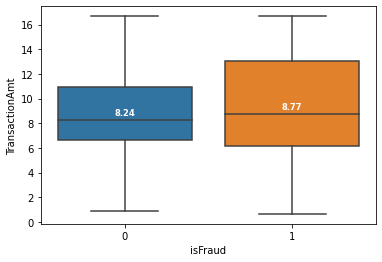

In [1252]:
ax = sns.boxplot(x='isFraud',y='TransactionAmt', data=df)
box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='TransactionAmt');

### M1-9

In [1253]:
column_details(regex='M\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M2:  object, 2, %46.3
['F' 'T' nan]

M3:  object, 2, %46.3
['F' 'T' nan]

M4:  object, 3, %47.49
['M0' 'M1' 'M2' nan]

M5:  object, 2, %59.48
['F' 'T' nan]

M6:  object, 2, %29.17
['F' 'T' nan]

M7:  object, 2, %58.73
['F' 'T' nan]

M8:  object, 2, %58.72
['F' 'T' nan]

M9:  object, 2, %58.72
['F' 'T' nan]



#### Multicolliniarity

In [1254]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [1255]:
pd.Series([cramers_v(df.M3,df[col]) for col in columns], index=columns).sort_values(ascending=False)

M3    0.999773
M2    0.668499
M9    0.214225
M8    0.080121
M7    0.049080
M4    0.032426
M5    0.028156
M6    0.024167
dtype: float64

In [1256]:
# cramers_v(df.M2,df.M3)

> We determined the correlation threshold upper than 0.8. Therefore, we don't drop M3.

#### Handling Outliers

> There is no outlier in M columns

#### Plots

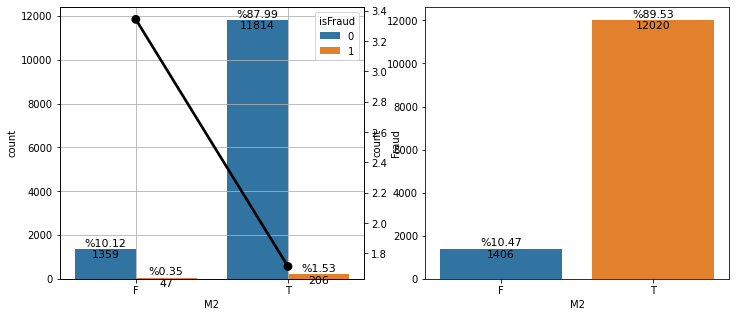

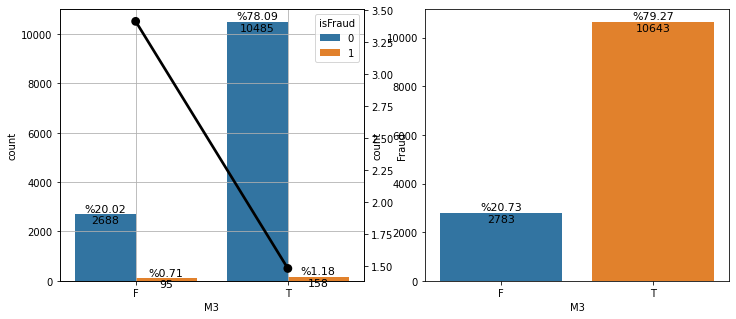

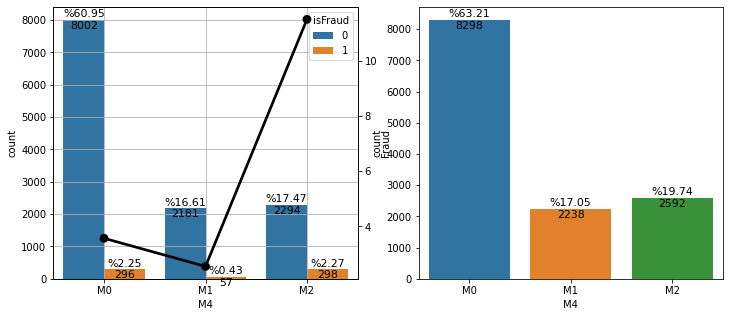

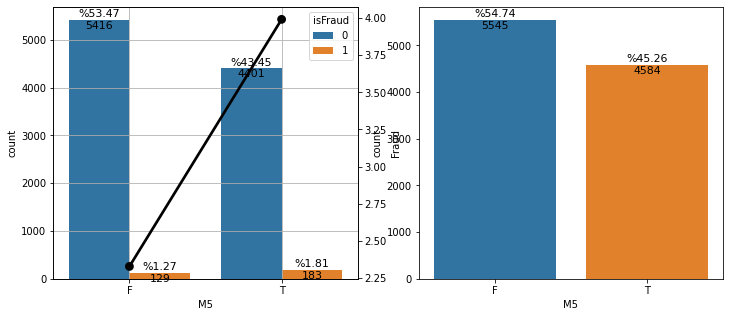

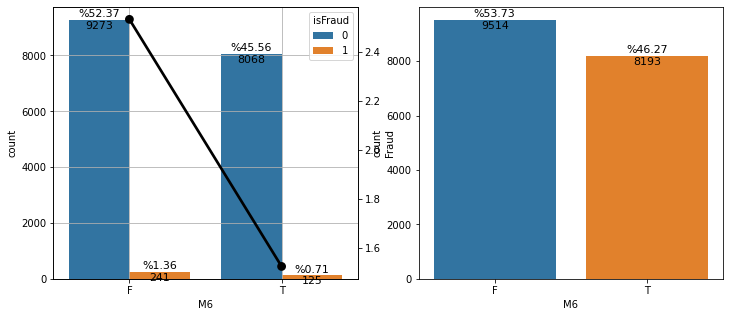

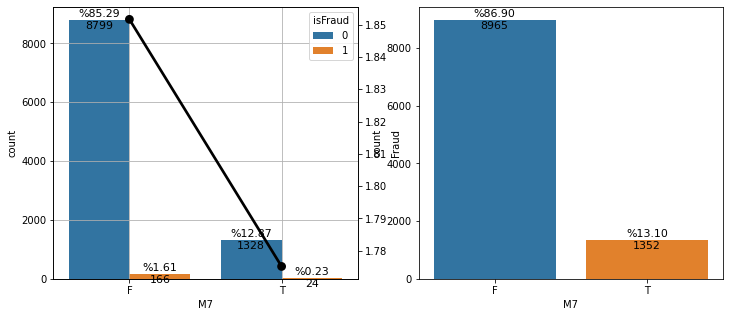

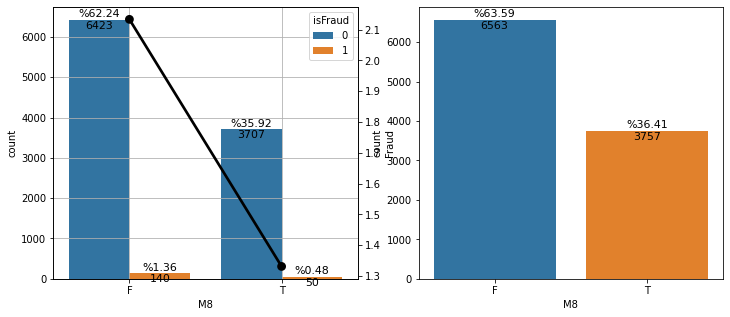

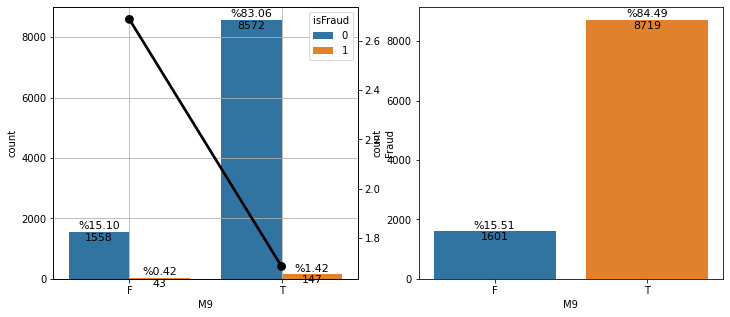

In [1257]:
for col in columns:
  plot_col(col, df=df, figsize=(12,5))

In [1258]:
# plot_cols(regex='M\d*', figsize=(7, 25), target='isFraud')

In [1259]:
# hist_countplot(regex='M\d*', figsize=(20, 10), nrow=2, ncolumn = 4)

In [1260]:
# box_countplot(regex='M\d*', figsize=(20, 10), nrow=4, ncolumn = 2)

### D1-15

In [1261]:
column_details(regex='^D\d', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float64, 639, %0.24
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

#### Multicolliniarity

In [1262]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [1263]:
# plt.figure(figsize=(15,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1264]:
# corrank(df[columns], 0.8)

In [1265]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'D12', 'D2', 'D6'}

In [1266]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [1267]:
columns=[col for col in df.columns if re.search('^D\d', col)]

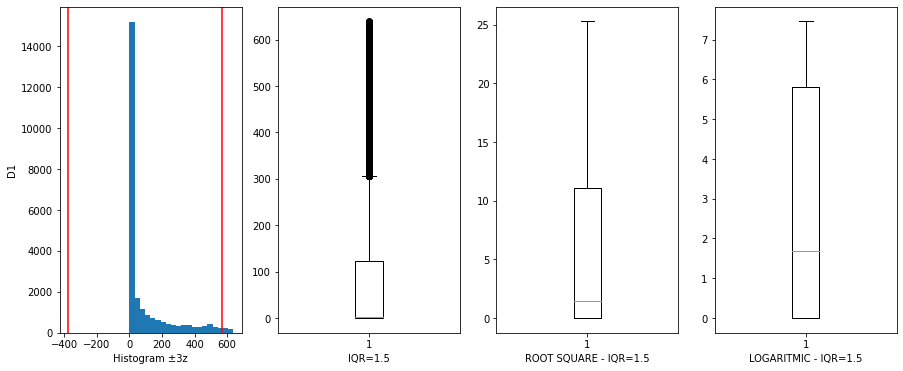

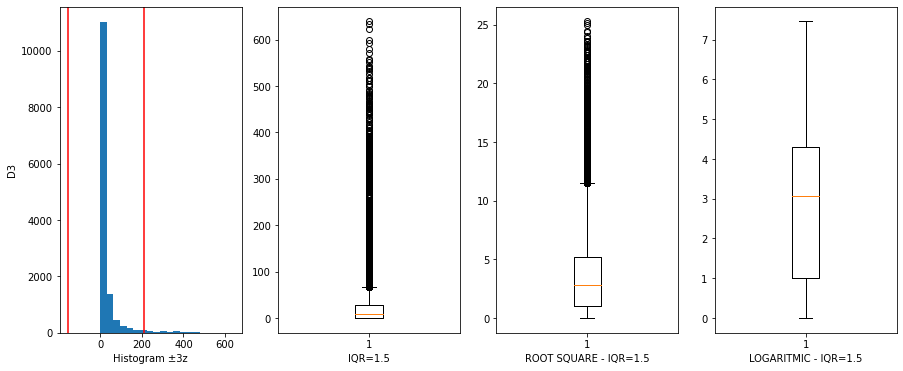

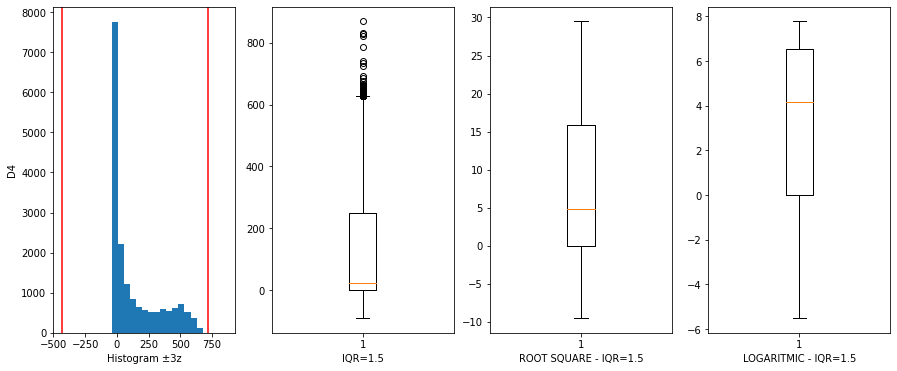

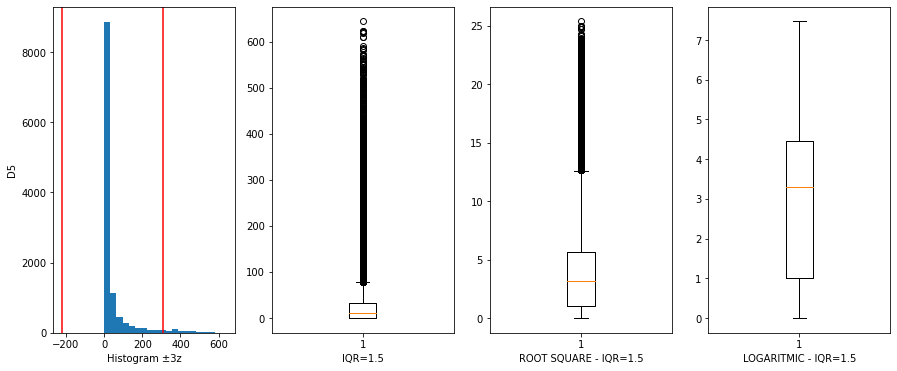

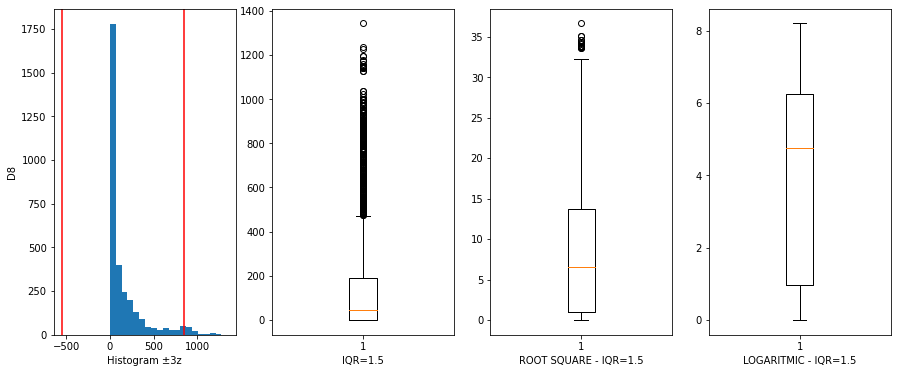

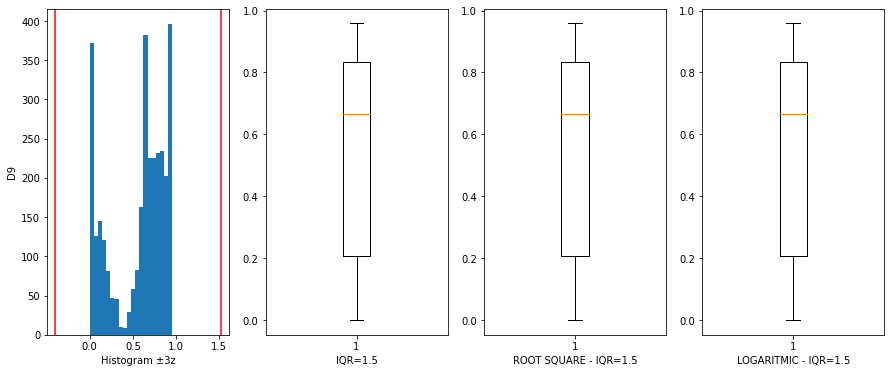

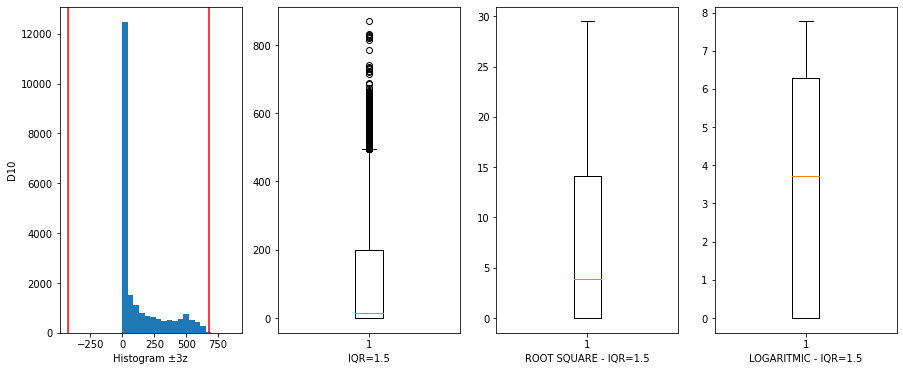

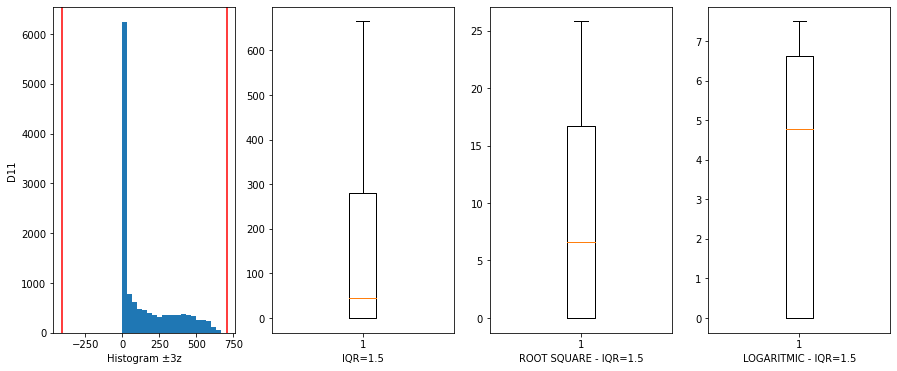

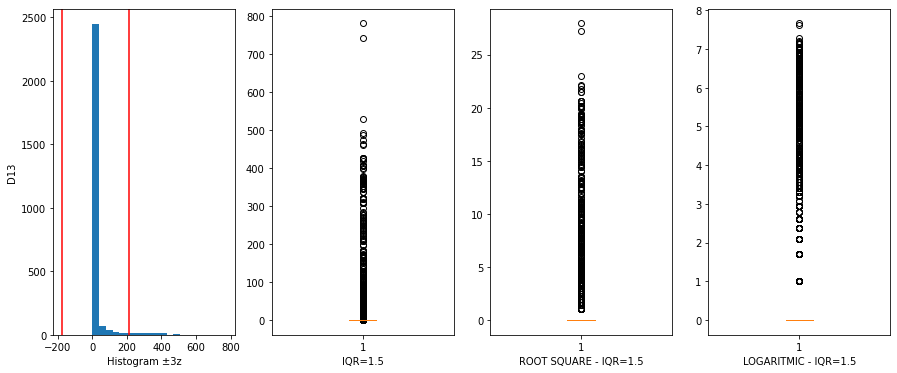

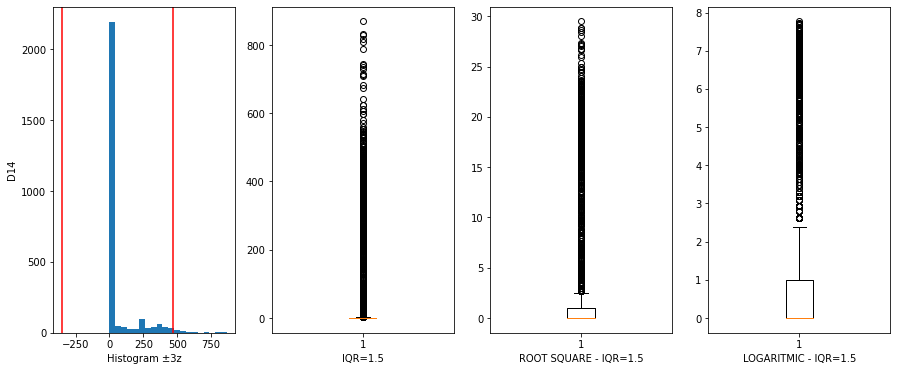

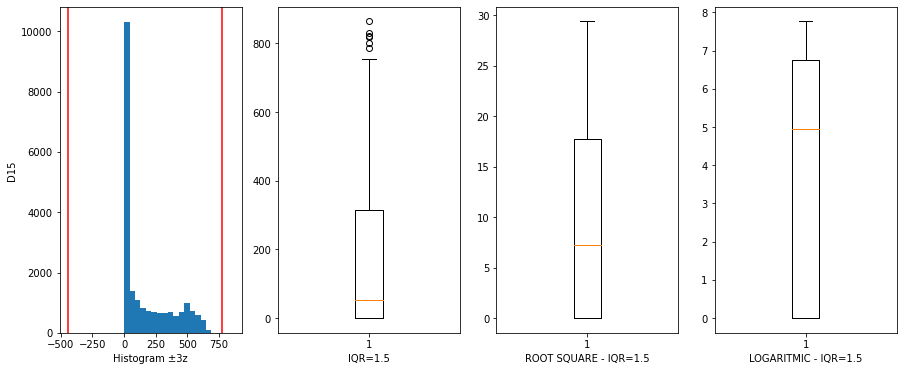

In [1268]:
for col in columns:
  col_plot(df[col].dropna().to_frame(), col)

In [1269]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [1270]:
# for col in columns[4:]:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [1271]:
f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
log_cols = ['D1','D3','D5','D8','D10','D15']
for col in log_cols:
  df[col] = df[col].apply(f_log)

In [1272]:
f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
df.D4 = df.D4.apply(f_sqrt)

In [1273]:
df.D14 = df.D14.apply(lambda x: 1 if x>0 else x)
df.D13 = df.D14.apply(lambda x: 1 if x>0 else x)

#### Plots

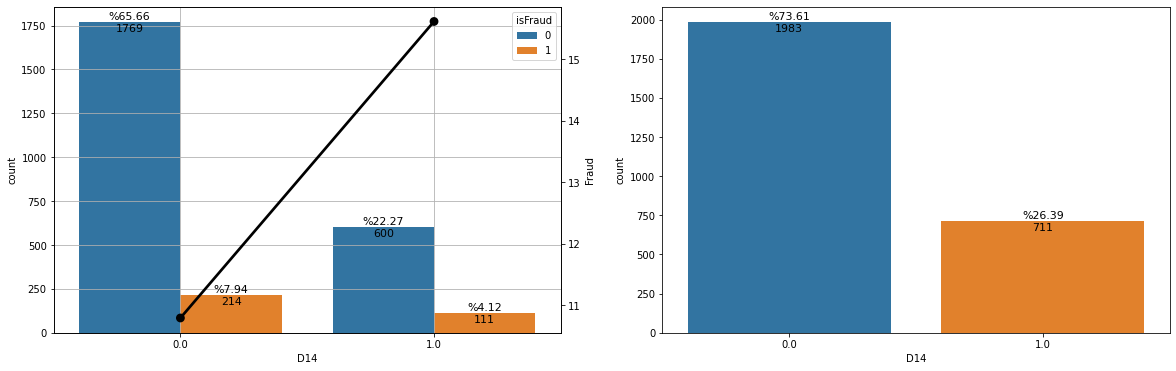

In [1277]:
plot_col('D14')

In [1278]:
# plot_cols(regex='^D\d', figsize=(30,50), target='isFraud')

In [1279]:
# hist_countplot(regex='^D\d', figsize=(20, 15), nrow=3, ncolumn = 5)

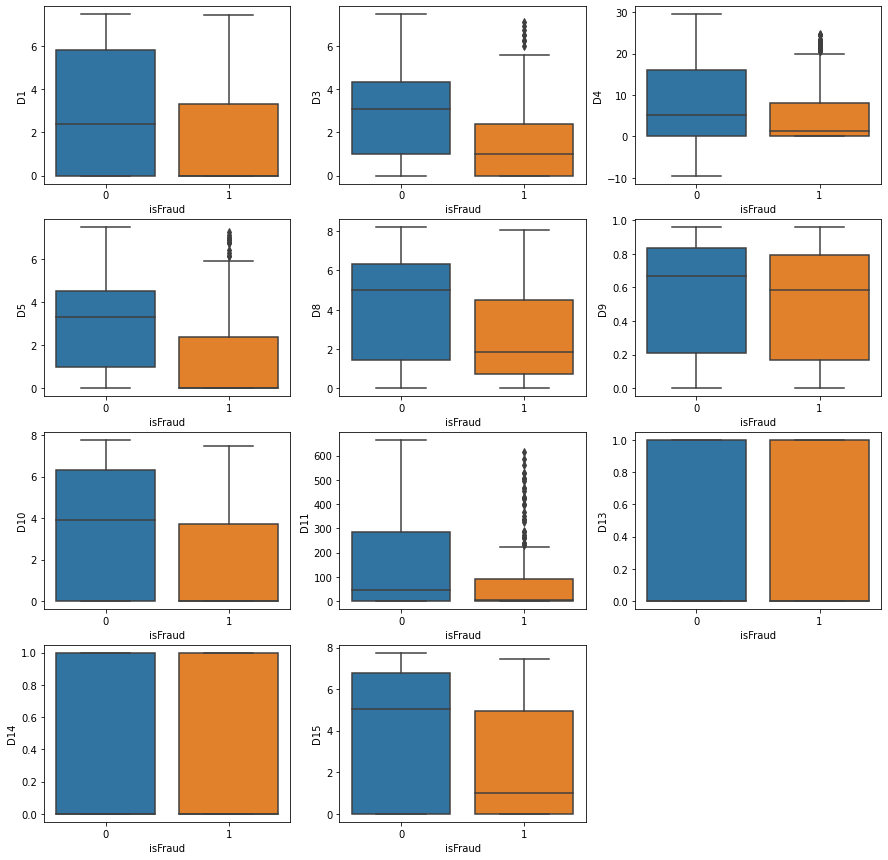

In [1280]:
box_countplot(regex='^D\d', figsize=(15, 15), nrow=4, ncolumn = 3, df=df)

### C1-14

In [1281]:
column_details(regex='^C\d', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  int64, 344, %0.0
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   50   51   52   53   55   56   57
   58   59   60   61   62   63   64   65   67   68   69   70   71   72
   73   74   75   76   77   78   79   80   81   82   83   84   85   86
   87   88   89   90   91   92   93   94   95   96   97   98   99  100
  101  102  103  104  105  106  107  108  109  110  111  112  113  114
  115  116  117  118  119  120  121  122  123  124  125  126  127  128
  129  130  131  132  133  134  135  136  137  138  139  140  141  142
  143  144  145  146  147  148  149  150  151  152  153  154  155  156
  157  158  159  160  161  162  163  164  165  166  167  168  169  170
  172  173  174  175  176  177  178  179  180  181  182  18

#### Multicolliarity

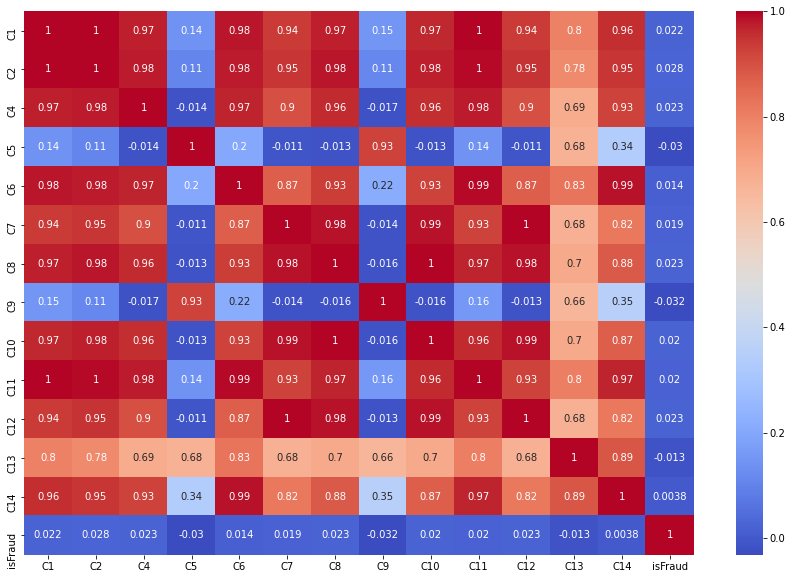

In [1282]:
plt.figure(figsize=(15,10))
sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1283]:
# corrank(df[columns], 0.8)

In [1284]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

In [1285]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [1286]:
columns=[col for col in df.columns if re.search('^C\d', col)]
columns

['C1', 'C5']

In [1287]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

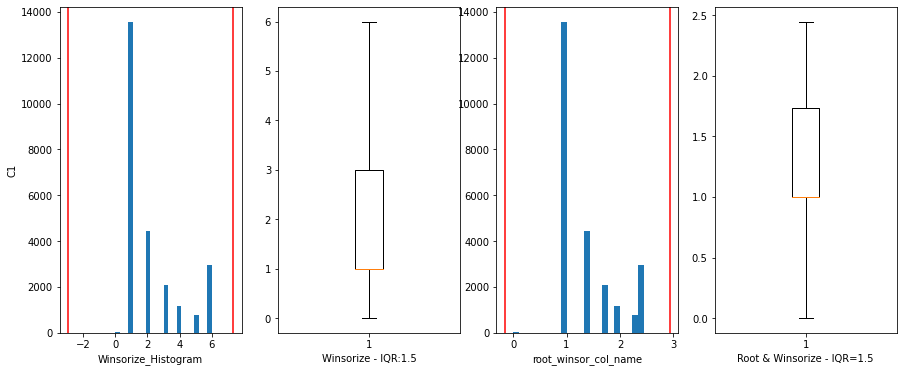

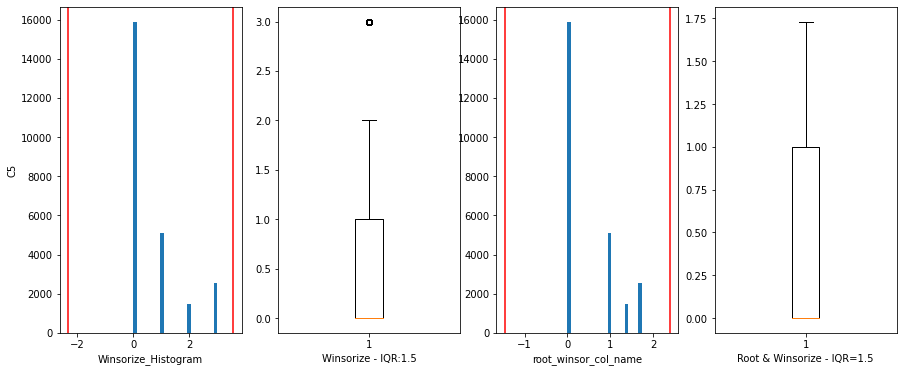

In [1288]:
for col in columns:
  plot_winsorize(df[col].dropna().to_frame(),col)

In [1289]:
# for col in columns:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [1290]:
for col in columns:
  df[col] = pd.Series( winsorize(df[col], limits=(0, 0.1)))

In [1291]:
# ax = sns.boxplot(x='isFraud',y='C1', data=df)
# box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='C1');

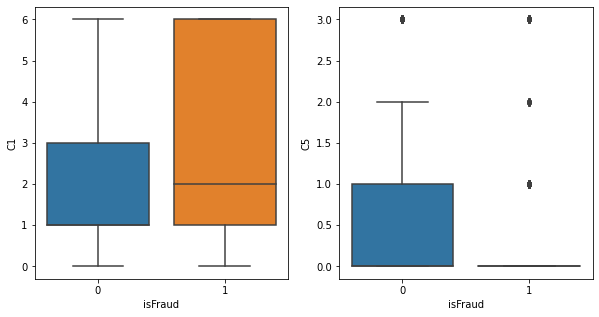

In [1292]:
box_countplot(regex='^C\d', figsize=(10, 5), nrow=1, ncolumn = 2, df=df)

#### Plots

In [1293]:
# plot_col('C1')

In [1294]:
# plot_cols(regex='^C\d', figsize=(20, 1), target='isFraud')

In [1295]:
# hist_countplot(regex='^C\d', figsize=(20, 15), nrow=3, ncolumn = 5)

In [1296]:
# box_countplot(regex='^C\d', figsize=(20,15), nrow=3, ncolumn = 5)

### dist1-2

In [1297]:
column_details(regex='^dist', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float64, 915, %59.91
[0.000e+00 1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00
 7.000e+00 8.000e+00 9.000e+00 1.000e+01 1.100e+01 1.200e+01 1.300e+01
 1.400e+01 1.500e+01 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01
 2.100e+01 2.200e+01 2.300e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01
 2.800e+01 2.900e+01 3.000e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01
 3.500e+01 3.600e+01 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01
 4.200e+01 4.300e+01 4.400e+01 4.500e+01 4.600e+01 4.700e+01 4.800e+01
 4.900e+01 5.000e+01 5.100e+01 5.200e+01 5.300e+01 5.400e+01 5.500e+01
 5.600e+01 5.700e+01 5.800e+01 5.900e+01 6.000e+01 6.100e+01 6.200e+01
 6.300e+01 6.400e+01 6.500e+01 6.600e+01 6.700e+01 6.800e+01 6.900e+01
 7.000e+01 7.100e+01 7.200e+01 7.300e+01 7.400e+01 7.500e+01 7.600e+01
 7.700e+01 7.800e+01 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.300e+01
 8.400e+01 8.500e+01 8.600e+01 8.700e+01 8.800e+01 8

In [1298]:
df.dist1.describe()

count    10023.000000
mean       112.698294
std        357.854276
min          0.000000
25%          3.000000
50%          8.000000
75%         23.000000
max       6466.000000
Name: dist1, dtype: float64

#### Multicolliarity

In [1299]:
# plt.figure(figsize=(4,4))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1300]:
# corrank(df[columns], 0.8)

In [1301]:
# drop_col = remove_collinear_features(df[columns],0.80)
# drop_col

In [1302]:
# df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [1303]:
columns=[col for col in df.columns if re.search('^dist', col)]

In [1304]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

In [1305]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

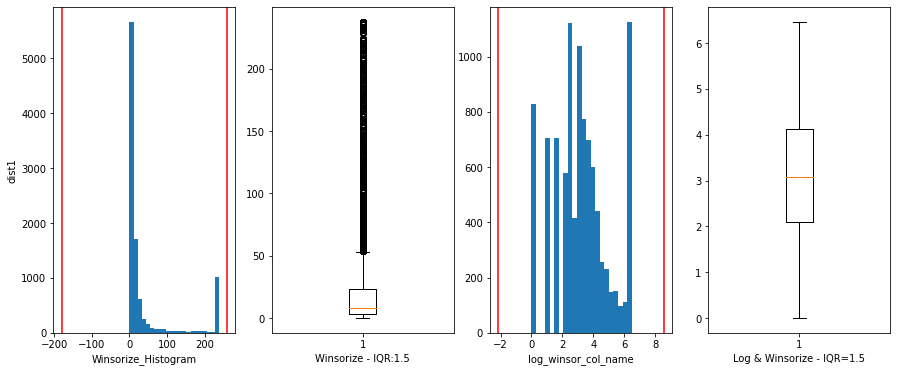

In [1306]:
for col in columns:
  plot_log_winsorize(df[col].dropna().to_frame(),col)

In [1307]:
df.dist1 = pd.Series( winsorize(df.dist1.apply(f_log), limits=(0, 0.1)))
df.dist1.describe()

count    10023.000000
mean         3.316068
std          2.029655
min          0.000000
25%          2.098612
50%          3.079442
75%          4.135494
max          9.774313
Name: dist1, dtype: float64

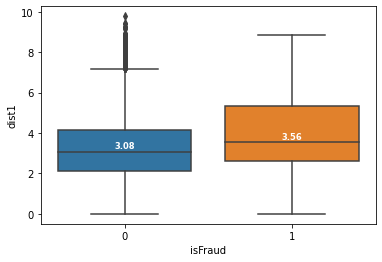

In [1308]:
ax = sns.boxplot(x='isFraud',y='dist1', data=df)
box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='dist1');

#### Plots

In [1309]:
# plot_col('dist1')

In [1310]:
# plot_cols(regex='^dist\d', figsize=(20, 8), target='isFraud')

In [1311]:
# hist_countplot(regex='^dist\d', figsize=(20, 8), nrow=1, ncolumn = 1)

In [1312]:
# box_countplot(regex='^dist\d', figsize=(20,8), nrow=1, ncolumn = 1)

### card1-6

In [1313]:
column_details(regex='^card', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

card1:  int64, 3979, %0.0
[ 1008  1012  1030 ... 18378 18385 18390]

card2:  float64, 492, %1.47
[100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.
 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213.
 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227.
 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241.
 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255.
 256. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266.

#### card3, card5

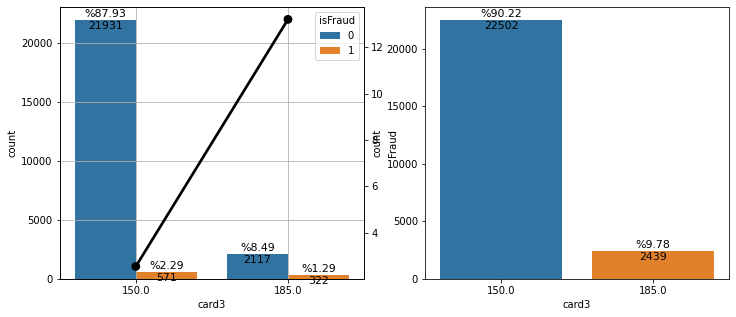

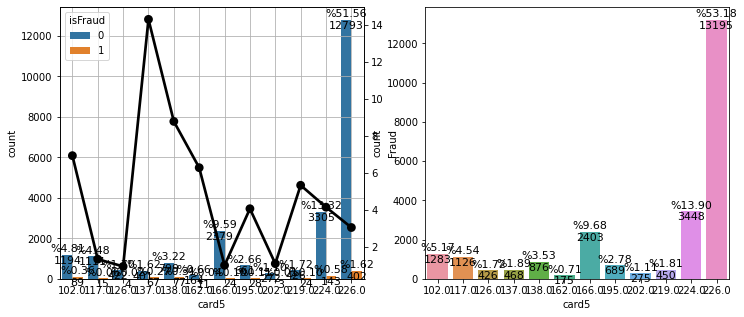

In [1314]:
for col in ['card3', 'card5']:
  df[col] = simplify_column(col, df=df, rate=0.005 )
  plot_col(col, df=df, figsize=(12,5))

#### Multicolliarity

In [1315]:
# plt.figure(figsize=(8,5))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [1316]:
# corrank(df[columns], 0.8)

In [1317]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

set()

In [1318]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [1319]:
columns=[col for col in df.columns if re.search('^card', col)]

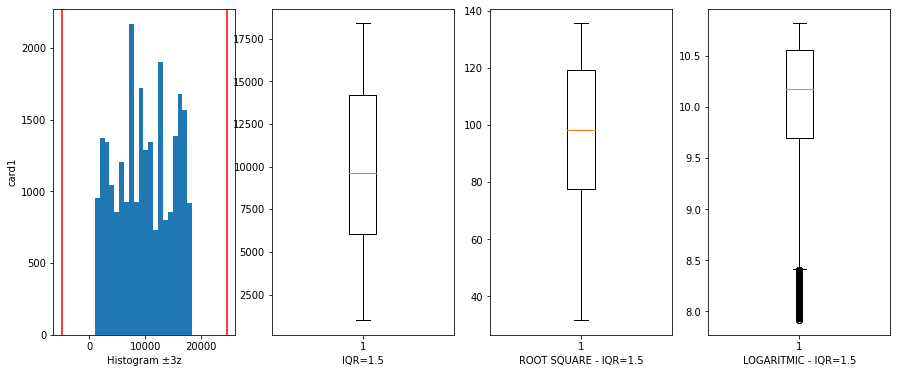

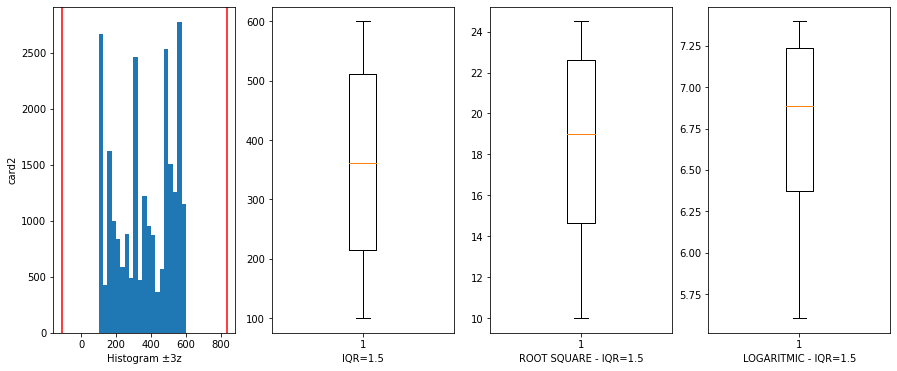

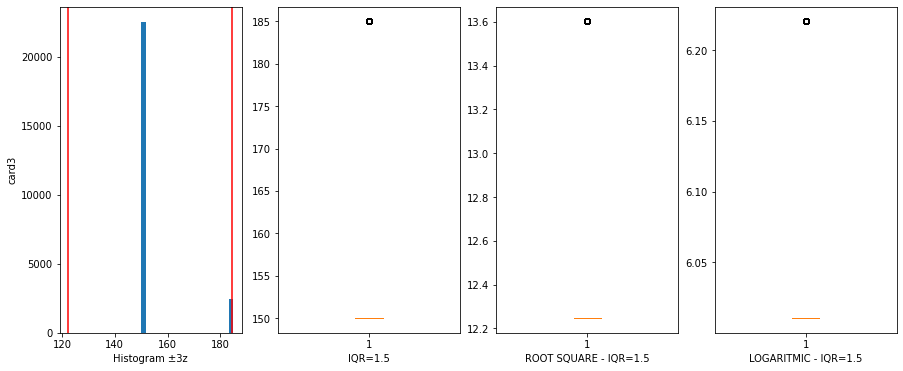

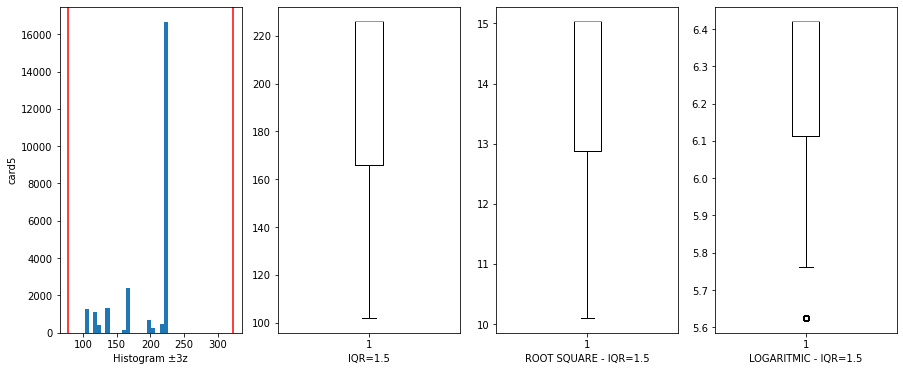

In [1320]:
for col in columns:
  if df[col].dtype!='O':
    col_plot(df[col].dropna().to_frame(),col)

In [1321]:
# for col in columns:
#   if df[col].dtype!='O':
#     plot_winsorize(df[col].dropna().to_frame(),col)

> card3-4-6 columns are categoric, The rest dont have any outlier problem.

#### Plots

In [1322]:
# plot_cols(regex='^card*', figsize=(30, 15), target='isFraud')

In [1323]:
# hist_countplot(regex='^card*', figsize=(30, 15), nrow=2, ncolumn = 3)

In [1324]:
# box_countplot(regex='^card*', figsize=(30, 15), nrow=2, ncolumn = 3)

In [1331]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda.csv')